In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from datetime import date,timedelta
import datetime as dt

import seaborn as sns
import squarify
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance

# Metrics
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap.umap_ as umap
from sklearn.decomposition import PCA
import scipy.spatial.distance as ssd 

# ML algortihms clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from kmodes.kprototypes import KPrototypes

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

# Module perso : helpers
import helpers # Le module du fichier python helper.py
import PCA_NR # Module avec fonctions de Nicolas Rangeon cours Openclassrooms

from tqdm import tqdm

pd.set_option("display.max_rows", 5000)
pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from IPython.core.display import HTML 

## <span class="bg-info"> 1. Chargement de la table RFM<span>

In [2]:
# chargement de la table segmentation RFM 
df_rfm = pd.read_csv('df_rfm_segmentation_olist.csv')
df_rfm.drop('Unnamed: 0', axis = 1, inplace = True)

In [3]:
df_rfm['RFM_Note'] = df_rfm[['R_Quartile','F_Quartile','M_Quartile']].sum(axis=1)

In [4]:
df_rfm.head()

Unnamed: 0.1                customer_unique_id  récence  fréquence  \
0             0  0000366f3b9a7992bf8c76cfdf3221e2      112          1   
1             1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1   
2             2  0000f46a3911fa3c0805444483337064      537          1   
3             3  0000f6ccb0745a6a4b88665a16c9f078      321          1   
4             4  0004aac84e0df4da2b147fca70cf8255      288          1   

   valeur_monétaire  R_Quartile  F_Quartile  M_Quartile  RFMScore  \
0            141.90           1           4           2       142   
1             27.19           2           4           4       244   
2             86.22           4           4           3       443   
3             43.62           3           4           4       344   
4            196.89           3           4           2       342   

          segment  RFM_Note  
0  Autres clients         7  
1  Autres clients        10  
2  Autres clients        11  
3  Autres clients        11  
4  Autres clients         9

In [5]:
df_rfm.groupby(['RFMScore']).size().sort_values(ascending=False)[:5]

RFMScore
244    5611
444    5609
144    5598
443    5585
343    5541
dtype: int64

## <span class="bg-info"> 2. Segmentation des clients en 3 : or, argent, bronze<span>

In [6]:
def segments(df):
    if df['RFM_Note'] < 5 :
        return 'Or'
    elif (df['RFM_Note'] > 5) and (df['RFM_Note'] <= 9 ):
        return 'Argent'
    else:  
        return 'Bronze'

df_rfm['General_Segment'] = df_rfm.apply(segments,axis=1)

df_rfm.groupby('General_Segment').agg({'récence':'mean','fréquence':'mean',
                                    'valeur_monétaire':['mean','count']}).round(1)

récence fréquence valeur_monétaire       
                   mean      mean             mean  count
General_Segment                                          
Argent            181.9       1.1            202.4  50004
Bronze            333.5       1.1            113.0  35860
Or                107.4       2.6            617.0   5269

In [7]:
df_rfm.head()

Unnamed: 0.1                customer_unique_id  récence  fréquence  \
0             0  0000366f3b9a7992bf8c76cfdf3221e2      112          1   
1             1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1   
2             2  0000f46a3911fa3c0805444483337064      537          1   
3             3  0000f6ccb0745a6a4b88665a16c9f078      321          1   
4             4  0004aac84e0df4da2b147fca70cf8255      288          1   

   valeur_monétaire  R_Quartile  F_Quartile  M_Quartile  RFMScore  \
0            141.90           1           4           2       142   
1             27.19           2           4           4       244   
2             86.22           4           4           3       443   
3             43.62           3           4           4       344   
4            196.89           3           4           2       342   

          segment  RFM_Note General_Segment  
0  Autres clients         7          Argent  
1  Autres clients        10          Bronze  
2  Autres clients        11          Bronze  
3  Autres clients        11          Bronze  
4  Autres clients         9          Argent

In [8]:
df_rfm.groupby('General_Segment').agg({'General_Segment' : 'count'})

General_Segment
General_Segment                 
Argent                     50004
Bronze                     35860
Or                          5269

In [9]:
df_client_or = df_rfm[df_rfm.General_Segment == 'Or']

In [10]:
df_client_or.shape

(5269, 12)

## <span class="bg-info"> 3. Segmentation des clients or avec k-means<span>

In [11]:
# Chargement de la table indicateurs clients
df_clients_total = pd.read_csv('data_clients_olist.csv')

In [12]:
df_clients_total.head()

customer_unique_id  geolocation_lat  geolocation_lng  \
0  0000366f3b9a7992bf8c76cfdf3221e2       -23.335331       -46.828647   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       -23.567395       -46.792957   
2  0000f46a3911fa3c0805444483337064       -27.543787       -48.625680   
3  0000f6ccb0745a6a4b88665a16c9f078        -1.311011       -48.482884   
4  0004aac84e0df4da2b147fca70cf8255       -23.504368       -47.466156   

   récence  fréquence  valeur_monétaire  an_dernier_achat  mois_dernier_achat  \
0      112          1          4.955123              2018                   5   
1      115          1          3.302849              2018                   5   
2      537          1          4.456902              2017                   3   
3      321          1          3.775516              2017                  10   
4      288          1          5.282645              2017                  11   

   jour_dernier_achat  heure_dernier_achat  jour_préféré_des_achats  \
0                  10                   10                        3   
1                   7                   11                        0   
2                  10                   21                        4   
3                  12                   20                        3   
4                  14                   19                        1   

   panier_moyen  payment_value_max  facilités_paiement  note_moy_avis  \
0      4.866765             141.90                 8.0            5.0   
1      2.939162              27.19                 1.0            4.0   
2      4.234107              86.22                 8.0            3.0   
3      3.257712              43.62                 4.0            4.0   
4      5.192957             196.89                 6.0            5.0   

             catégorie_+_achetée moyen_paiement_prefere  \
0                 home_furniture            credit_card   
1                  hygien_beauty            credit_card   
2                     stationery            credit_card   
3  computer_electronic_telephony            credit_card   
4  computer_electronic_telephony            credit_card   

  order_purchase_timestamp  
0      2018-05-10 10:56:27  
1      2018-05-07 11:11:27  
2      2017-03-10 21:05:03  
3      2017-10-12 20:29:41  
4      2017-11-14 19:45:42

In [13]:
#On garde les clients or de la base de données client total
df_clients_or_total = df_clients_total[df_clients_total.customer_unique_id.isin(df_client_or.customer_unique_id)]
print(df_clients_or_total.shape)

(5269, 18)


In [14]:
# Suppression colonnes
df_clients_or_total.drop('order_purchase_timestamp', axis = 1, inplace = True)
df_clients_or_total.set_index('customer_unique_id', inplace=True)
df_clients_or_kp = df_clients_or_total.copy()

In [15]:
# Suppression colonnes qualitatives en vue de l'ACP
df_clients_or_total.drop(['moyen_paiement_prefere', 'catégorie_+_achetée'] , axis = 1, inplace = True)

## <span class="bg-success"> 3.1 Préparation : données centrées et réduites<span>

In [16]:
# préparation des données pour l'ACP
X = df_clients_or_total.values
features = df_clients_or_total.columns

# Centrage et Réduction
#Nous mettons à l'échelle les données afin de garantir que Les unités des variables n'ont pas d'impact sur les distances
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

## <span class="bg-success"> 3.2 Réduction de dimension : ACP<span>

In [17]:
pca = PCA()
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

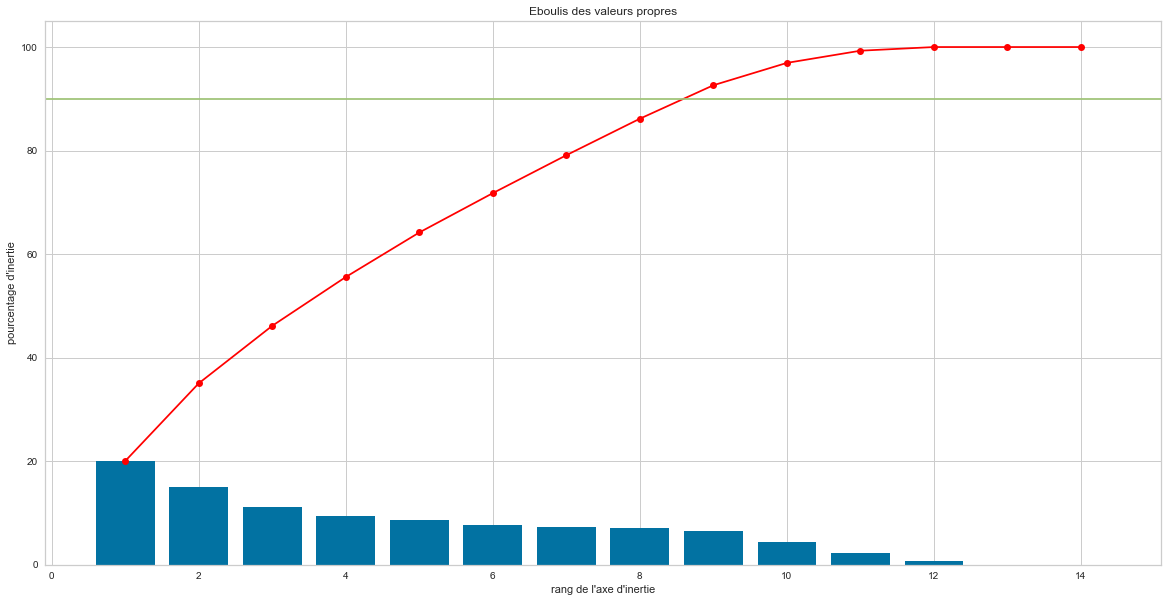

In [18]:
# Eboulis des valeurs propres
PCA_NR.display_scree_plot(pca)

In [19]:
n_comp = 9
pca = PCA(n_components = n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [20]:
df_clients_or_PCA = pd.DataFrame(X_projected, index = df_clients_or_total.index, columns = ["F"+str(i+1)for i in range(9)])
df_clients_or_PCA.shape

(5269, 9)

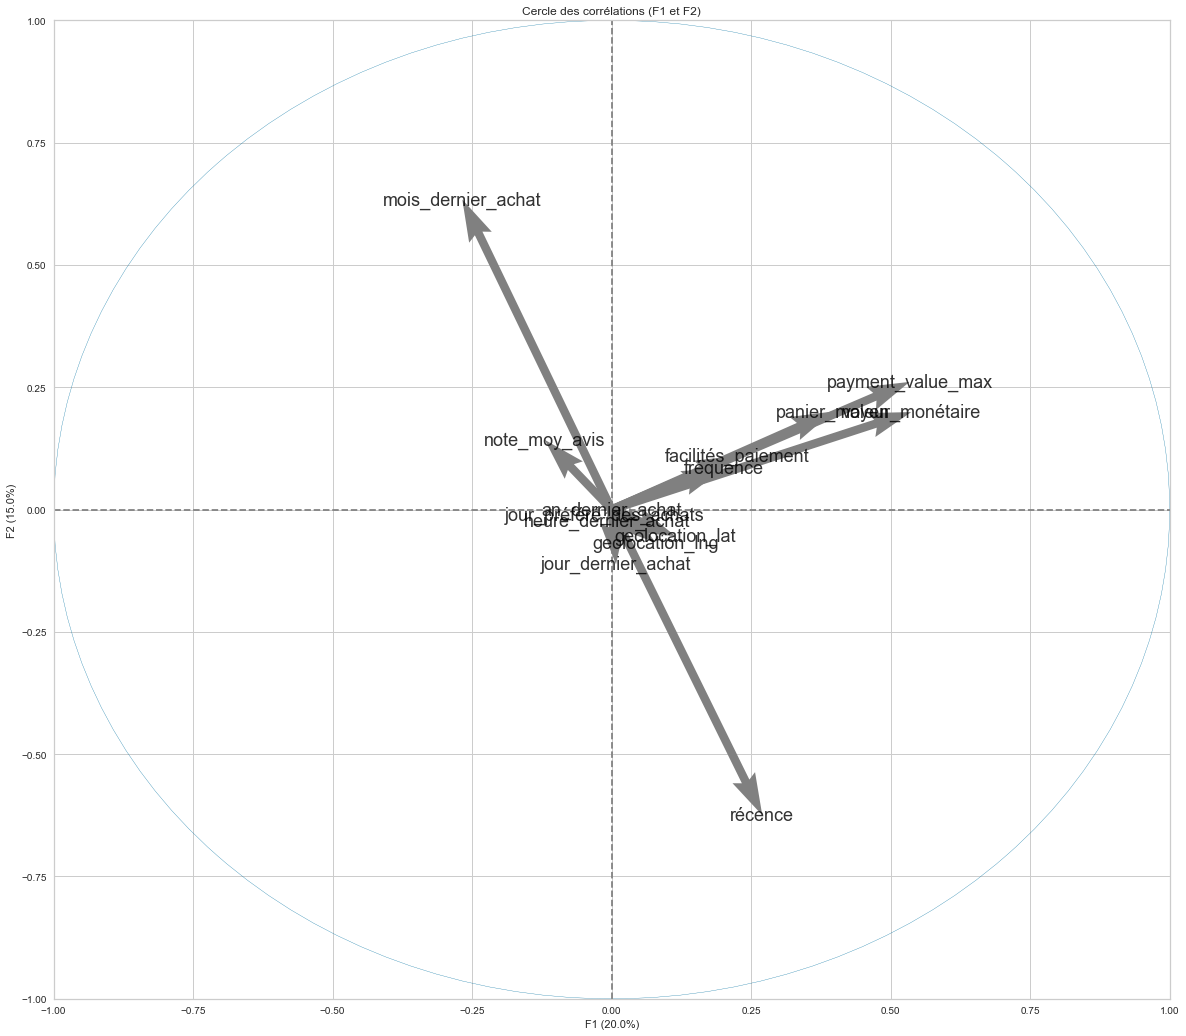

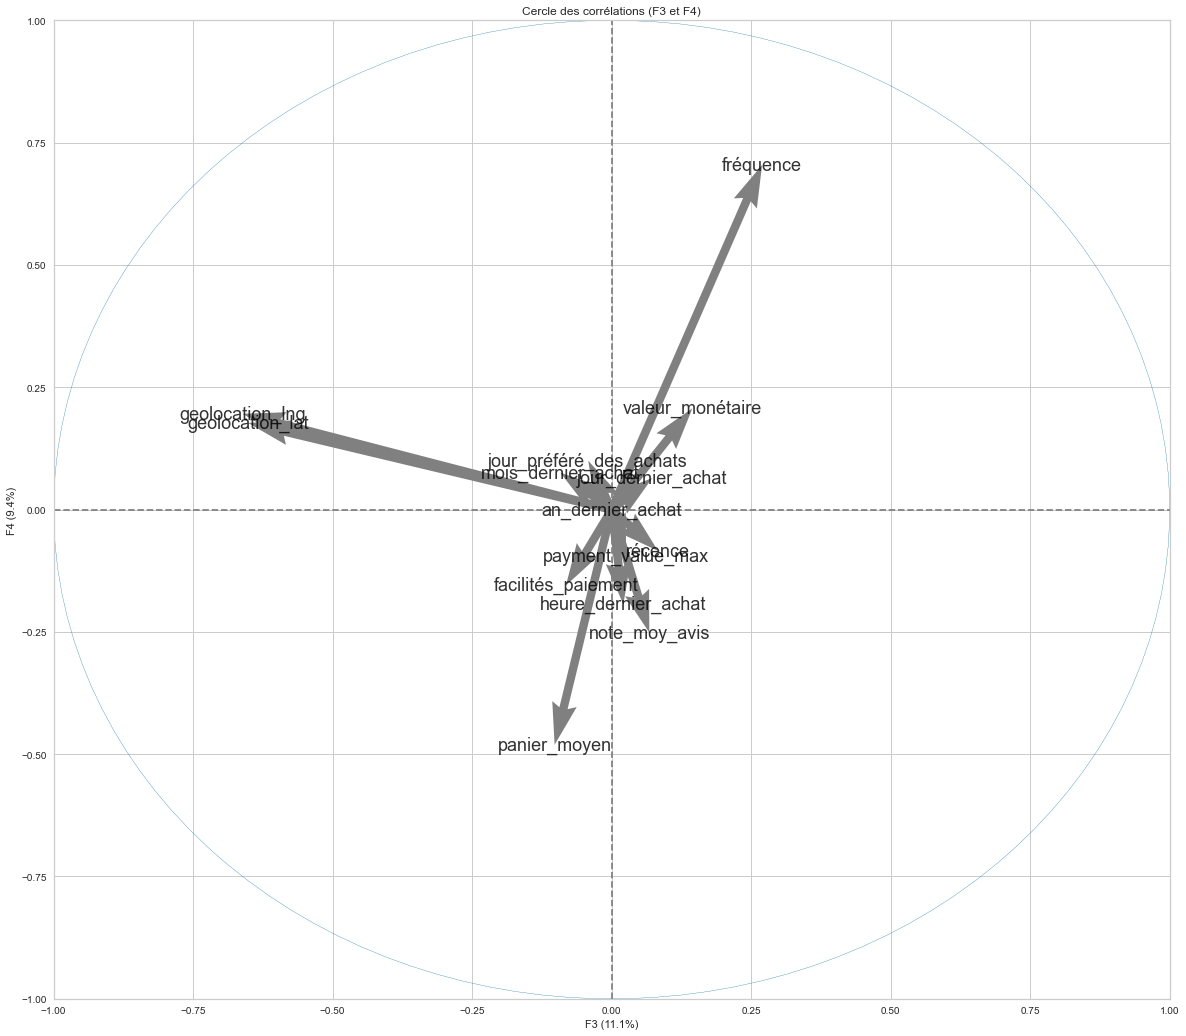

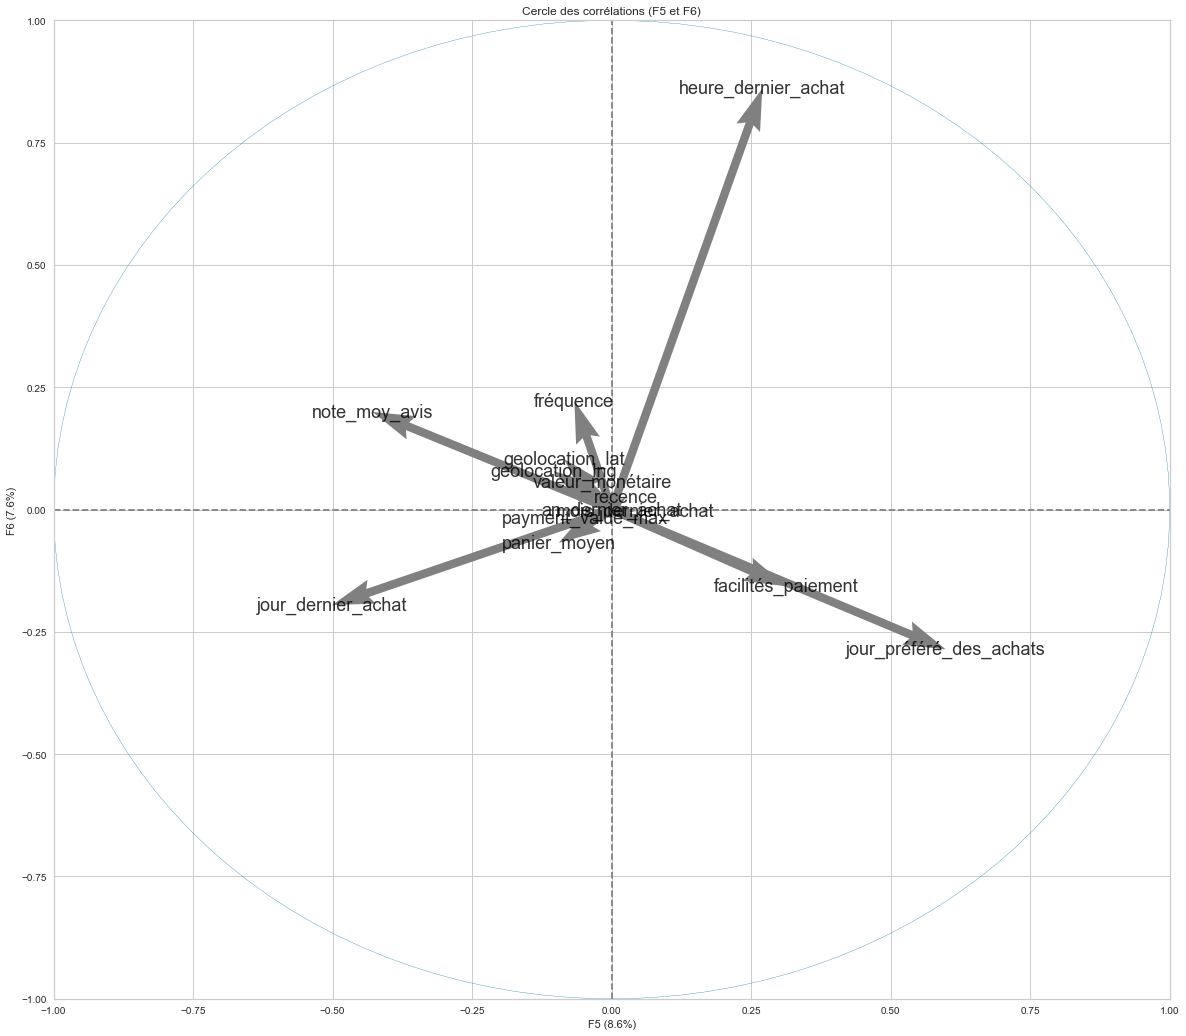

In [21]:
# Cercle des corrélations
pcs = pca.components_
PCA_NR.display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features)) # Plan factoriel pour les 2 premières composantes de l'ACP 
PCA_NR.display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features)) # Plan factoriel pour les composantes 3 et 4 de l'ACP 
PCA_NR.display_circles(pcs, n_comp, pca, [(4,5)], labels = np.array(features)) # Plan factoriel pour les composantes 5 et 6 de l'ACP 

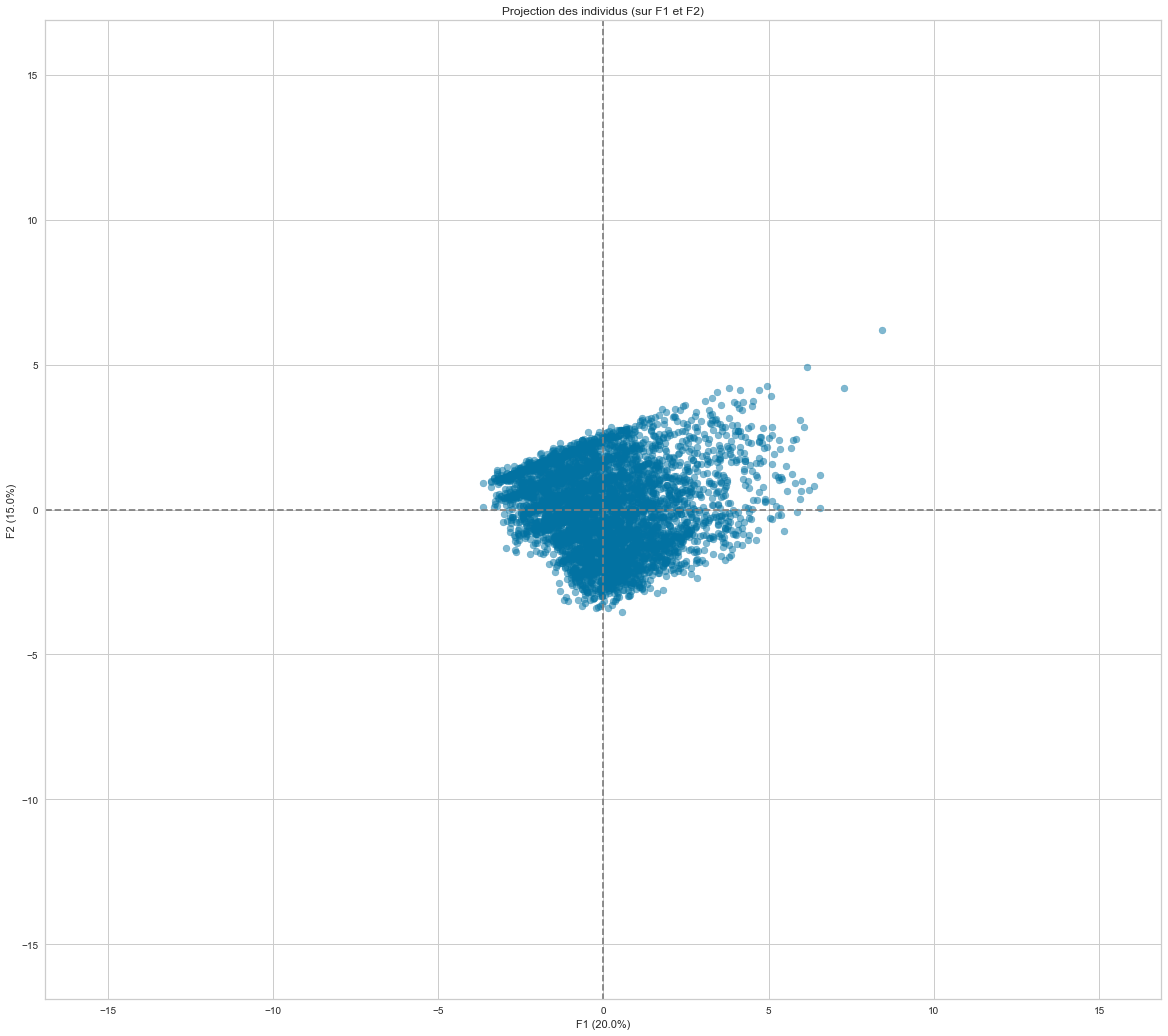

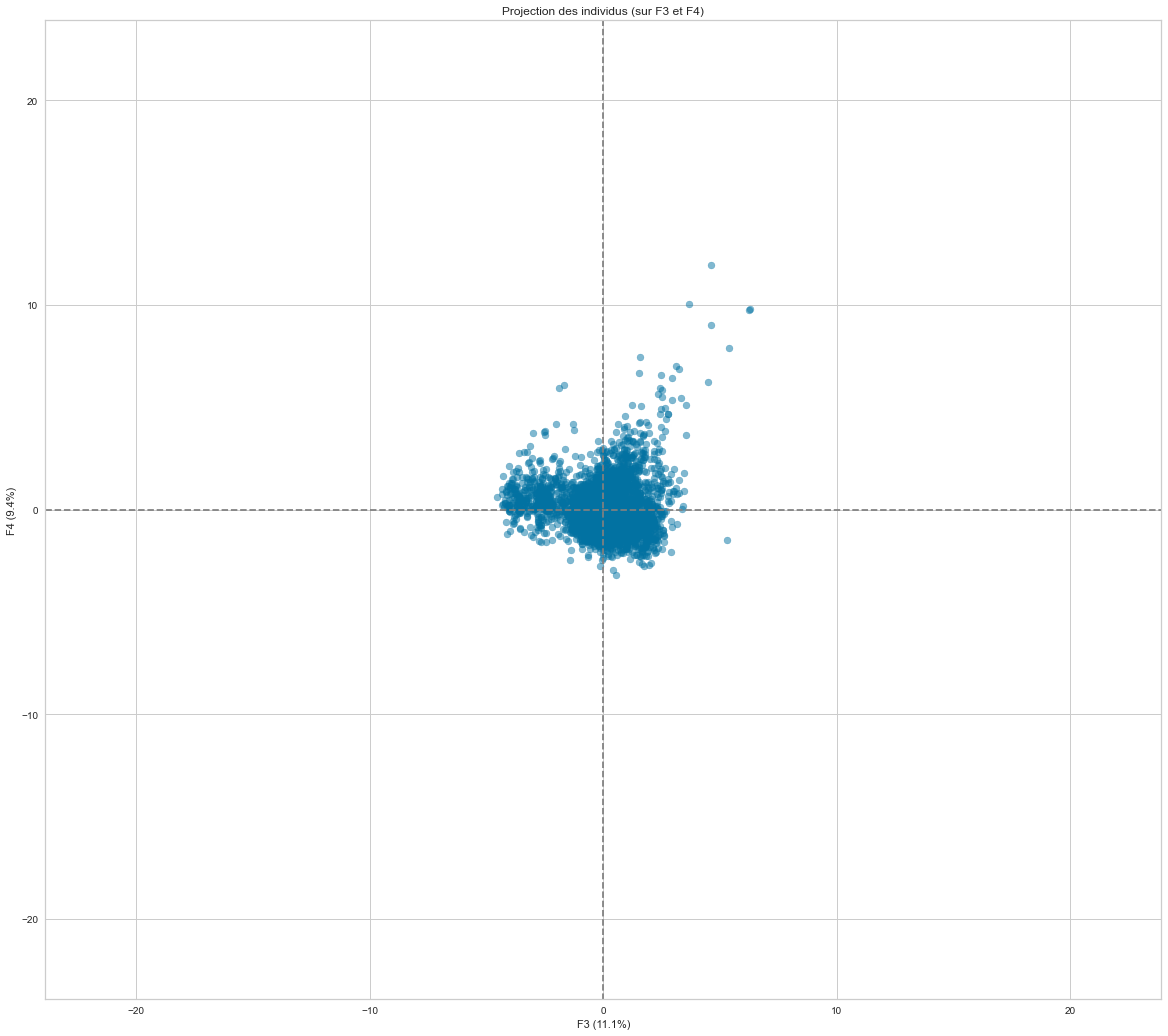

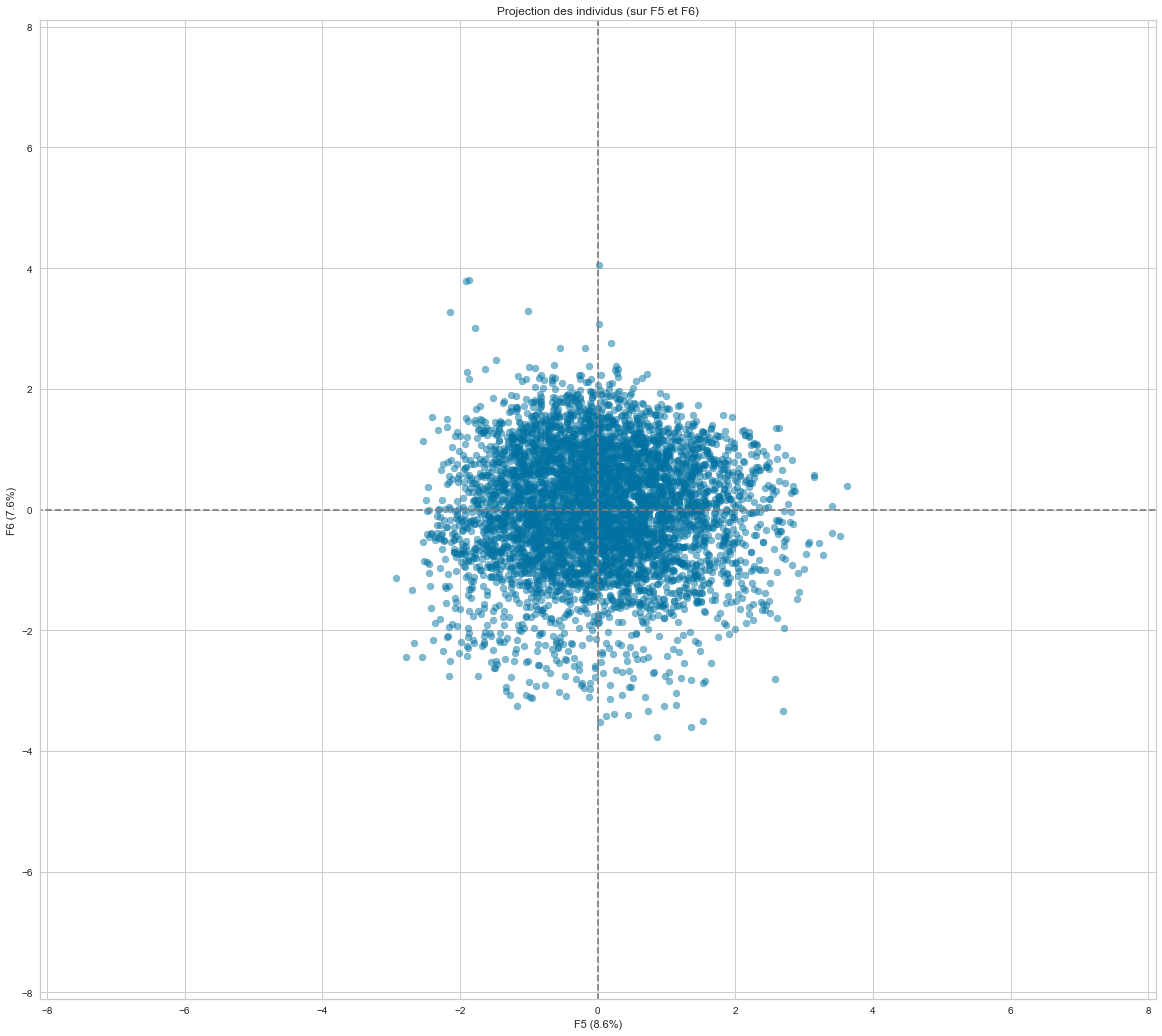

In [22]:
# Projection des individus
PCA_NR.display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha = 0.5)

## <span class="bg-success"> 3.3 ACP et K-means<span> 

In [23]:
km_scores= []
km_silhouette = []
db_score = []
for i in tqdm(range(2,10)):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

  0%|          | 0/8 [00:00<?, ?it/s]

Score for number of cluster(s) 2: -59700.01554446274


 12%|█▎        | 1/8 [00:00<00:03,  2.16it/s]

Silhouette score for number of cluster(s) 2: 0.1316107420283944
Davies Bouldin score for number of cluster(s) 2: 2.476769429450555
Score for number of cluster(s) 3: -53550.73340474331


 25%|██▌       | 2/8 [00:00<00:02,  2.26it/s]

Silhouette score for number of cluster(s) 3: 0.12773841090347893
Davies Bouldin score for number of cluster(s) 3: 2.171875883456394
Score for number of cluster(s) 4: -50341.90624616807


 38%|███▊      | 3/8 [00:01<00:02,  2.27it/s]

Silhouette score for number of cluster(s) 4: 0.13273019355550247
Davies Bouldin score for number of cluster(s) 4: 1.986418406695817
Score for number of cluster(s) 5: -48066.414915039764


 50%|█████     | 4/8 [00:01<00:01,  2.24it/s]

Silhouette score for number of cluster(s) 5: 0.10989758248646021
Davies Bouldin score for number of cluster(s) 5: 2.153043646388892
Score for number of cluster(s) 6: -45742.75579267281


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

Silhouette score for number of cluster(s) 6: 0.11056513917587181
Davies Bouldin score for number of cluster(s) 6: 2.0870361419641905
Score for number of cluster(s) 7: -43893.01435658264


 75%|███████▌  | 6/8 [00:02<00:00,  2.03it/s]

Silhouette score for number of cluster(s) 7: 0.10393155132061704
Davies Bouldin score for number of cluster(s) 7: 2.1185859412229258
Score for number of cluster(s) 8: -42661.658818276395


 88%|████████▊ | 7/8 [00:03<00:00,  1.94it/s]

Silhouette score for number of cluster(s) 8: 0.09370802541080558
Davies Bouldin score for number of cluster(s) 8: 2.121493471408292
Score for number of cluster(s) 9: -41464.42984102661


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

Silhouette score for number of cluster(s) 9: 0.08713729771203162
Davies Bouldin score for number of cluster(s) 9: 2.13865879425677


### <span class="bg-warning"> 3.3.1 Méthode "du coude"<span>

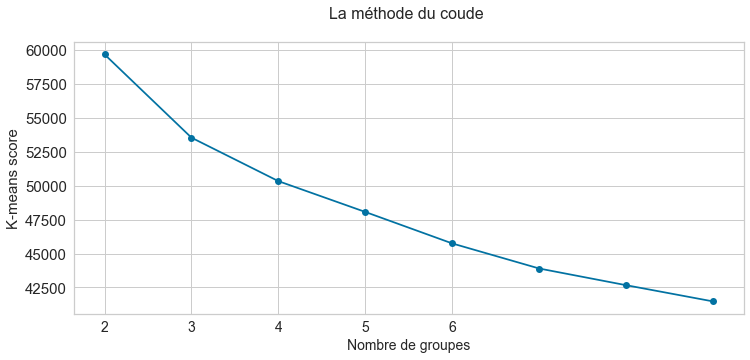

In [24]:
plt.figure(figsize=(12,5))
plt.title("La méthode ""du coude"" ""\n",fontsize=16)
plt.plot([i for i in range(2,10)],km_scores, marker = 'o')
plt.grid(True)
plt.xlabel("Nombre de groupes",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('methode_du_coude_Km.png')
plt.show()

### <span class="bg-warning"> 3.3.2 Coefficient de silhouette<span> 

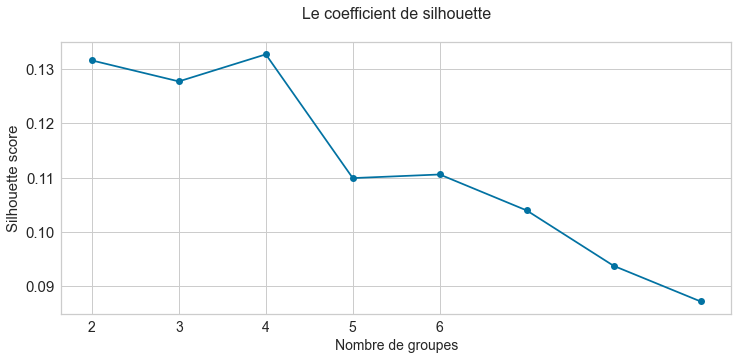

In [25]:
plt.figure(figsize=(12,5))
plt.title("Le coefficient de silhouette""\n",fontsize=16)
plt.plot([i for i in range(2,10)], km_silhouette, marker = 'o')
plt.grid(True)
plt.xlabel("Nombre de groupes",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('the_silhouette_coefficient_method_km.png')
plt.show()

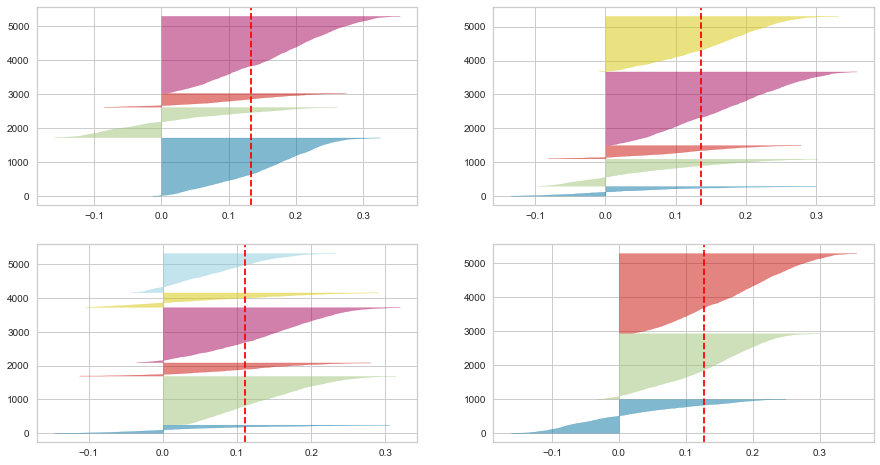

In [26]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [3, 4, 5, 6]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-2][mod])
    visualizer.fit(X_scaled)  

### <span class="bg-warning"> 3.3.3 Indice de Davies Bouldin<span> 

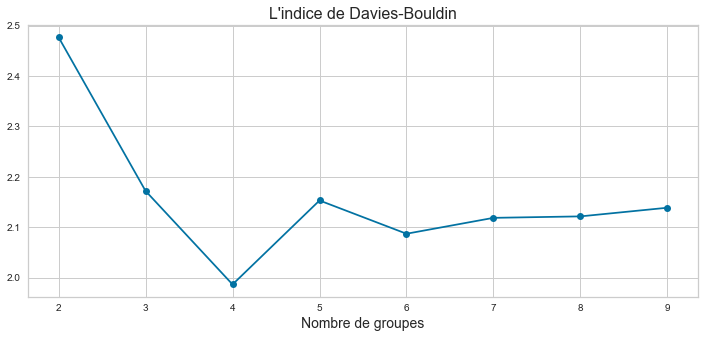

In [27]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)], db_score, marker = 'o')
plt.grid(True)
plt.xlabel('Nombre de groupes',fontsize=14)
plt.title("L'indice de Davies-Bouldin",fontsize=16 )
plt.savefig('davies_bouldin_score_km.png')
plt.show()

### <span class="bg-warning"> 3.3.4 Conclusion<span> 
__Conclusions :__ le nombre k optimal de groupes selon les différents indices :
- __Méthode du coude__ : 3 (ou 4)
- __Coefficient de silhouette__ : 4 
- __Indice de Davies Bouldin__ : 4

__Nous allons donc essayer avec 4 clusters__

## <span class="bg-success"> 3.4 Segmentation avec K-means (k = 4)<span>

In [28]:
kmeans_pca_4 = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters_km_4 = kmeans_pca_4.fit(df_clients_or_PCA)
df_clients_or_PCA['Cluster4'] = kmeans_pca_4.labels_
kmeans_labels_pca_4 = kmeans_pca_4.labels_

In [29]:
pd.Series(kmeans_labels_pca_4).value_counts()

3    2245
1    1721
2     876
0     427
dtype: int64

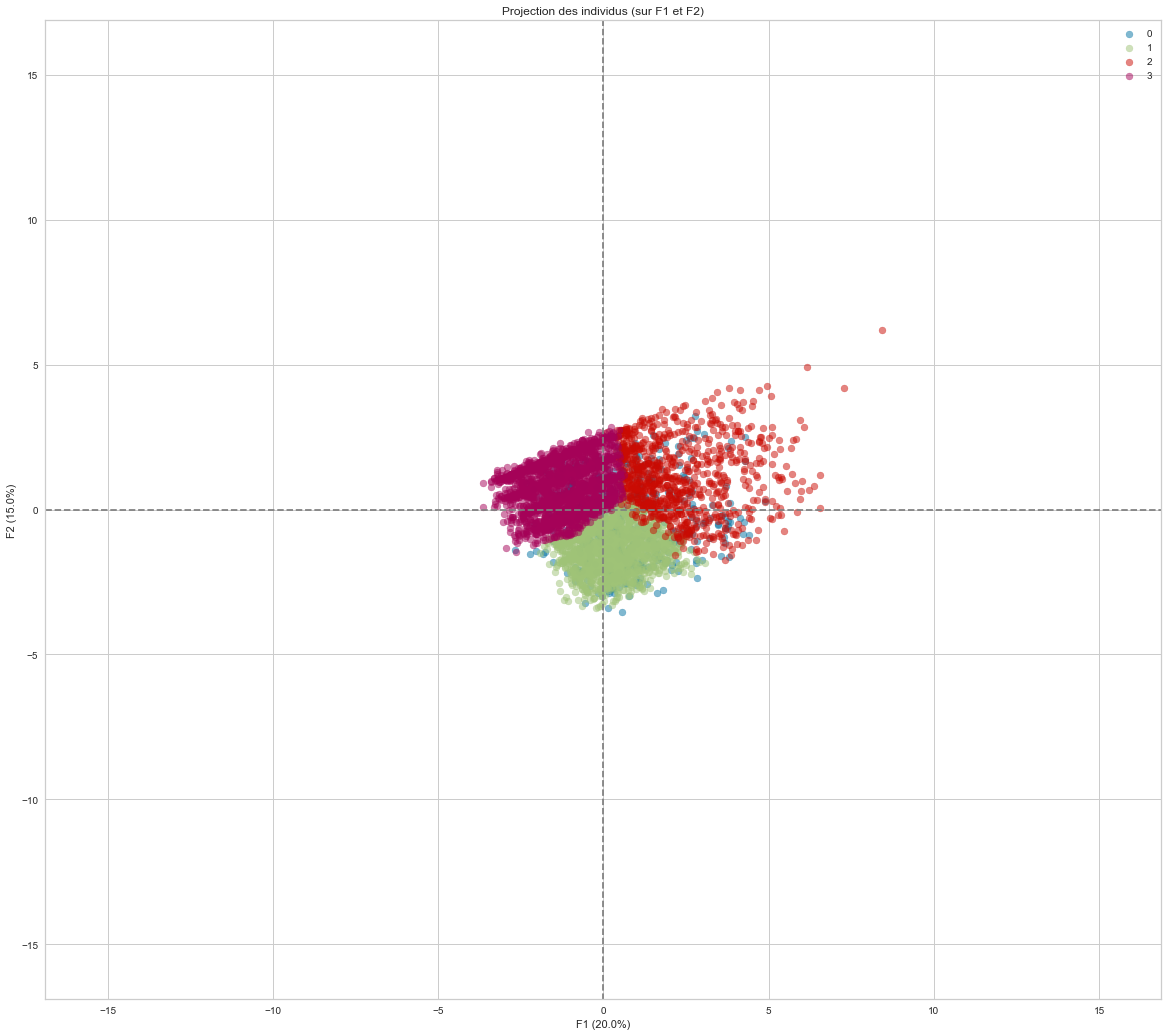

In [30]:
PCA_NR.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = kmeans_labels_pca_4, alpha = 0.5)

## <span class="bg-success"> 3.5 Interprétation des clusters (k=4)<span> 

### Table de données

In [31]:
# Table de données avec colonne cluster k=4 ajoutée
df_interpretation_or_PCA = pd.concat([df_clients_or_total, df_clients_or_PCA], axis=1)
df_interpretation_or_PCA.shape

(5269, 24)

In [32]:
# Table de données pour interpréter la segmentation des clients pour k=4
df_interpretation_km_4 = df_interpretation_or_PCA.groupby('Cluster4').agg(
                                            {'récence' : 'mean', 
                                             'valeur_monétaire' : 'mean',
                                             'fréquence' : 'mean',
                                            'an_dernier_achat' : 'mean',
                                            'mois_dernier_achat' : 'median',
                                            'panier_moyen': 'mean',
                                            'facilités_paiement' : 'median'})
df_interpretation_km_4.reset_index(inplace = True)
df_interpretation_km_4.head()

Cluster4     récence  valeur_monétaire  fréquence  an_dernier_achat  \
0         0  118.843091          6.120349   2.461358              2018   
1         1  169.375363          5.986434   2.440442              2018   
2         2  103.062785          7.223125   3.799087              2018   
3         3   59.497105          5.691527   2.364811              2018   

   mois_dernier_achat  panier_moyen  facilités_paiement  
0                   5      4.504128                 3.0  
1                   3      4.282640                 2.0  
2                   5      5.032150                 4.5  
3                   7      4.108205                 2.0

### Visualisation graphique

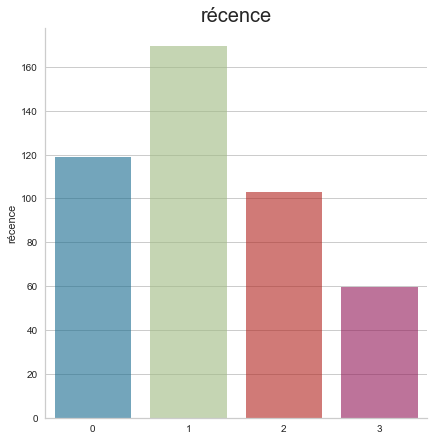

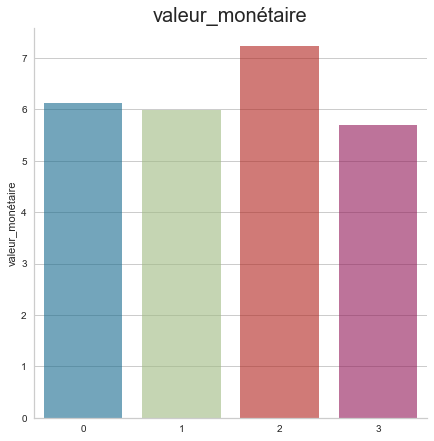

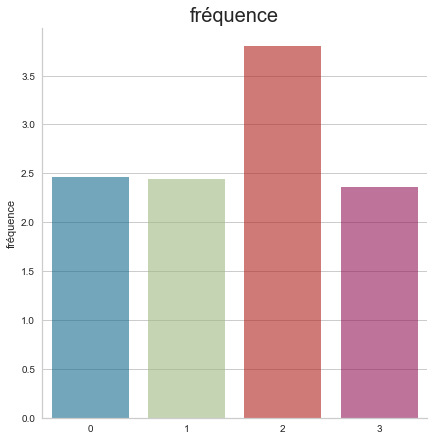

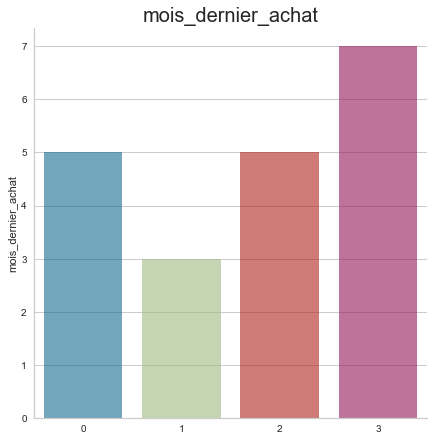

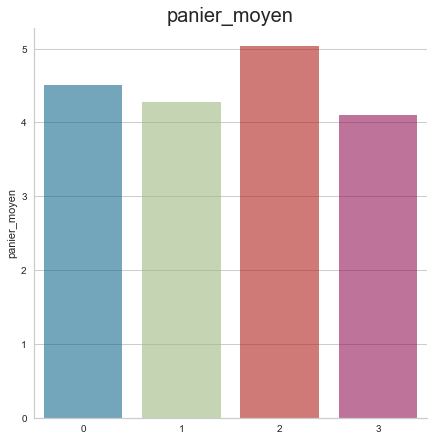

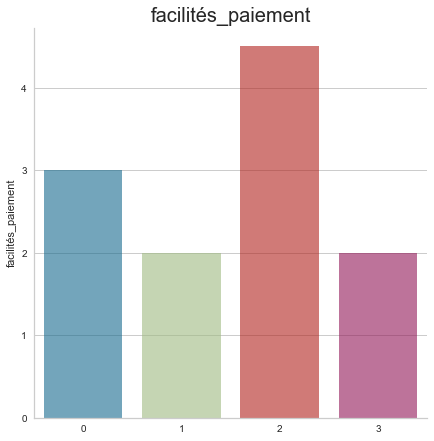

In [33]:
#Graphiques utiles à l'interprétation des clusters
colonnes = ['récence', 'valeur_monétaire', 'fréquence', 'mois_dernier_achat', 'panier_moyen', 'facilités_paiement']
for col in colonnes :
    g = sns.catplot(
    data= df_interpretation_km_4, kind="bar", x="Cluster4", y=col, ci="sd",alpha=.6, height=6)
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

### Interprétation des 4 clusters
- __cluster 0__ : Meilleurs clients "lambdas"
- __cluster 1__ : Meilleurs clients en voie de perdition
- __cluster 2__ : Meilleurs clients qui plébiscitent des facilités de paiement
- __cluster 3__ : Meilleurs nouveaux clients

## <span class="bg-info"> 4. Segmentation des clients avec k- prototypes<span>

In [34]:
print(df_clients_or_kp.shape)
df_clients_or_kp.head()

(5269, 16)


geolocation_lat  geolocation_lng  récence  \
customer_unique_id                                                            
00053a61a98854899e70ed204dd4bafe       -25.429683       -49.274635      183   
000fbf0473c10fc1ab6f8d2d286ce20c       -23.089035       -47.214419       35   
0015752e079902b12cd00b9b7596276b       -23.550547       -46.595194       27   
001928b561575b2821c92254a2327d06       -23.650874       -46.718411        5   
0025795df7a7d077c4c90162fa820085       -23.502760       -46.573620       37   

                                  fréquence  valeur_monétaire  \
customer_unique_id                                              
00053a61a98854899e70ed204dd4bafe          2          6.731448   
000fbf0473c10fc1ab6f8d2d286ce20c          4          7.278988   
0015752e079902b12cd00b9b7596276b          2          5.008232   
001928b561575b2821c92254a2327d06          2          5.797940   
0025795df7a7d077c4c90162fa820085          2          6.059497   

                                  an_dernier_achat  mois_dernier_achat  \
customer_unique_id                                                       
00053a61a98854899e70ed204dd4bafe              2018                   2   
000fbf0473c10fc1ab6f8d2d286ce20c              2018                   7   
0015752e079902b12cd00b9b7596276b              2018                   8   
001928b561575b2821c92254a2327d06              2018                   8   
0025795df7a7d077c4c90162fa820085              2018                   7   

                                  jour_dernier_achat  heure_dernier_achat  \
customer_unique_id                                                          
00053a61a98854899e70ed204dd4bafe                  28                   11   
000fbf0473c10fc1ab6f8d2d286ce20c                  26                    9   
0015752e079902b12cd00b9b7596276b                   2                   18   
001928b561575b2821c92254a2327d06                  24                   21   
0025795df7a7d077c4c90162fa820085                  24                   11   

                                  jour_préféré_des_achats  panier_moyen  \
customer_unique_id                                                        
00053a61a98854899e70ed204dd4bafe                        2      5.252273   
000fbf0473c10fc1ab6f8d2d286ce20c                        3      4.268998   
0015752e079902b12cd00b9b7596276b                        3      3.397858   
001928b561575b2821c92254a2327d06                        4      4.226031   
0025795df7a7d077c4c90162fa820085                        1      4.488074   

                                  payment_value_max  facilités_paiement  \
customer_unique_id                                                        
00053a61a98854899e70ed204dd4bafe             419.18                 3.0   
000fbf0473c10fc1ab6f8d2d286ce20c             362.38                 1.0   
0015752e079902b12cd00b9b7596276b              74.82                 3.0   
001928b561575b2821c92254a2327d06             164.81                 6.0   
0025795df7a7d077c4c90162fa820085             214.08                 3.0   

                                  note_moy_avis     catégorie_+_achetée  \
customer_unique_id                                                        
00053a61a98854899e70ed204dd4bafe            1.0          sports_leisure   
000fbf0473c10fc1ab6f8d2d286ce20c            5.0  art_music_cinema_books   
0015752e079902b12cd00b9b7596276b            5.0     fashion_accessories   
001928b561575b2821c92254a2327d06            2.0          home_furniture   
0025795df7a7d077c4c90162fa820085            1.0              stationery   

                                 moyen_paiement_prefere  
customer_unique_id                                       
00053a61a98854899e70ed204dd4bafe            credit_card  
000fbf0473c10fc1ab6f8d2d286ce20c                 boleto  
0015752e079902b12cd00b9b7596276b            credit_card  
001928b561575b2821c92254a2327d06            credit_card  
0025795df7a7d077c4c90162fa820085       

In [35]:
df_clients_or_kp = df_clients_or_kp.drop('an_dernier_achat', axis = 1)

In [36]:
helpers.summarise(df_clients_or_kp)

n_missing  p_missing  n_unique    dtype
geolocation_lat                  0        0.0      3944  float64
geolocation_lng                  0        0.0      3954  float64
récence                          0        0.0       218    int64
fréquence                        0        0.0        18    int64
valeur_monétaire                 0        0.0      4637  float64
mois_dernier_achat               0        0.0         8    int64
jour_dernier_achat               0        0.0        31    int64
heure_dernier_achat              0        0.0        24    int64
jour_préféré_des_achats          0        0.0         7    int64
panier_moyen                     0        0.0      2430  float64
payment_value_max                0        0.0      4435  float64
facilités_paiement               0        0.0       114  float64
note_moy_avis                    0        0.0        74  float64
catégorie_+_achetée              0        0.0        18   object
moyen_paiement_prefere           0        0.0         4   object

In [37]:
df_clients_or_kp.dtypes

geolocation_lat            float64
geolocation_lng            float64
récence                      int64
fréquence                    int64
valeur_monétaire           float64
mois_dernier_achat           int64
jour_dernier_achat           int64
heure_dernier_achat          int64
jour_préféré_des_achats      int64
panier_moyen               float64
payment_value_max          float64
facilités_paiement         float64
note_moy_avis              float64
catégorie_+_achetée         object
moyen_paiement_prefere      object
dtype: object

In [62]:
df_clients_or_kp.reset_index(inplace = True)

In [63]:
df_clients_or_kp.drop('customer_unique_id', axis = 1, inplace = True)

In [81]:
df_UMAP = df_clients_or_kp.copy()

In [82]:
print(df_UMAP.shape)
df_UMAP.head()

(5269, 15)


geolocation_lat  geolocation_lng  récence  fréquence  valeur_monétaire  \
0       -25.429683       -49.274635      183          2          6.731448   
1       -23.089035       -47.214419       35          4          7.278988   
2       -23.550547       -46.595194       27          2          5.008232   
3       -23.650874       -46.718411        5          2          5.797940   
4       -23.502760       -46.573620       37          2          6.059497   

   mois_dernier_achat  jour_dernier_achat  heure_dernier_achat  \
0                   2                  28                   11   
1                   7                  26                    9   
2                   8                   2                   18   
3                   8                  24                   21   
4                   7                  24                   11   

   jour_préféré_des_achats  panier_moyen  payment_value_max  \
0                        2      5.252273             419.18   
1                        3      4.268998             362.38   
2                        3      3.397858              74.82   
3                        4      4.226031             164.81   
4                        1      4.488074             214.08   

   facilités_paiement  note_moy_avis     catégorie_+_achetée  \
0                 3.0            1.0          sports_leisure   
1                 1.0            5.0  art_music_cinema_books   
2                 3.0            5.0     fashion_accessories   
3                 6.0            2.0          home_furniture   
4                 3.0            1.0              stationery   

  moyen_paiement_prefere  
0            credit_card  
1                 boleto  
2            credit_card  
3            credit_card  
4            credit_card

### <span class="bg-success"> 4.1 UMAP<span>

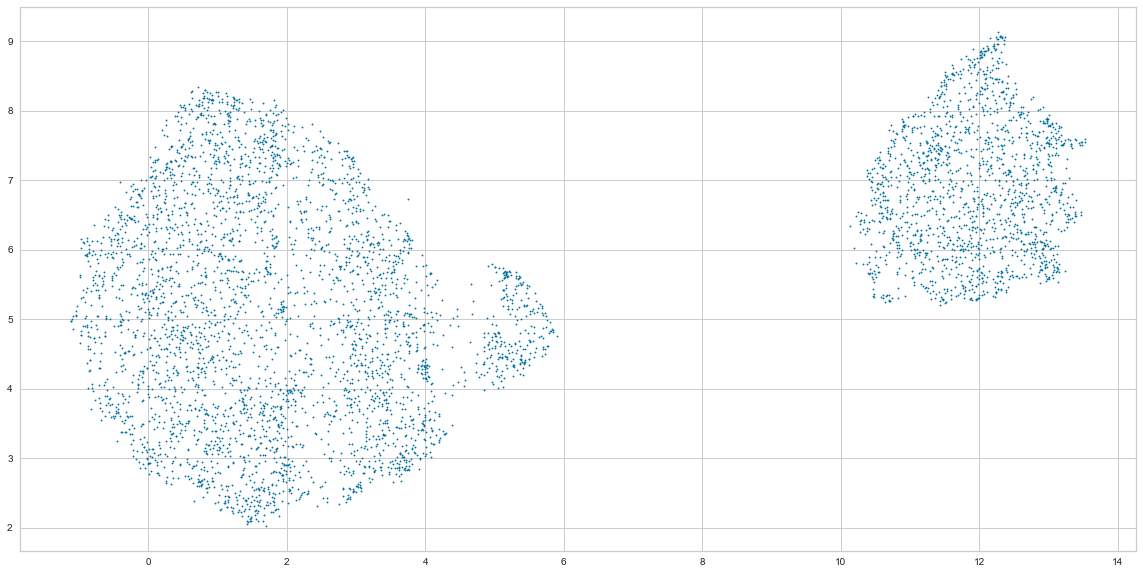

In [83]:
#Preprocessing numerical
numerical = df_UMAP.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df_UMAP.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_UMAP.select_dtypes(include='object').columns) / df_UMAP.shape[1]

#Embedding numerical & categorical
fit1 =umap.UMAP(metric='l2').fit(numerical)
fit2 =umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [84]:
categorical_weight

0.13333333333333333

#### <span class="bg-warning"> 6.3.1 Préparation des données - Recherche k optimal<span>

In [85]:
#One-Hot-Encoding
data = pd.get_dummies(df_UMAP)

#Pre-processing
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [86]:
km_scores= []
km_silhouette = []
db_score = []
for i in tqdm(range(2,7)):
    km = KMeans(n_clusters=i, random_state=0).fit(data)
    preds = km.predict(data)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(data)))
    km_scores.append(-km.score(data))
    
    silhouette = silhouette_score(data,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(data,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

  0%|          | 0/5 [00:00<?, ?it/s]

Score for number of cluster(s) 2: -172468.76611992726


 20%|██        | 1/5 [00:00<00:01,  2.25it/s]

Silhouette score for number of cluster(s) 2: 0.13318414658976493
Davies Bouldin score for number of cluster(s) 2: 2.9529172882787162
Score for number of cluster(s) 3: -165396.6814494321


 40%|████      | 2/5 [00:01<00:01,  2.09it/s]

Silhouette score for number of cluster(s) 3: 0.059702915680029445
Davies Bouldin score for number of cluster(s) 3: 3.4288756307126658
Score for number of cluster(s) 4: -160217.31342012284


 60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

Silhouette score for number of cluster(s) 4: 0.06594278230395798
Davies Bouldin score for number of cluster(s) 4: 2.784737260620214
Score for number of cluster(s) 5: -155142.4261384348


 80%|████████  | 4/5 [00:02<00:00,  2.01it/s]

Silhouette score for number of cluster(s) 5: 0.07284947531572925
Davies Bouldin score for number of cluster(s) 5: 2.4455861078527885
Score for number of cluster(s) 6: -149897.30384656246


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

Silhouette score for number of cluster(s) 6: 0.07767678346470955
Davies Bouldin score for number of cluster(s) 6: 2.1227076116510726


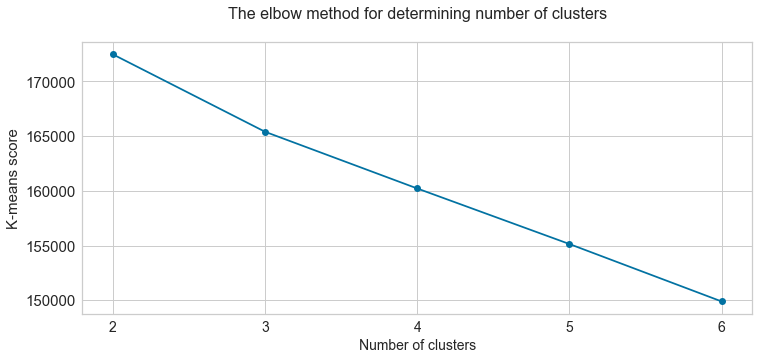

In [87]:
plt.figure(figsize=(12,5))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.plot([i for i in range(2,7)],km_scores, marker = 'o')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('the_elbow_method.png')
plt.show()

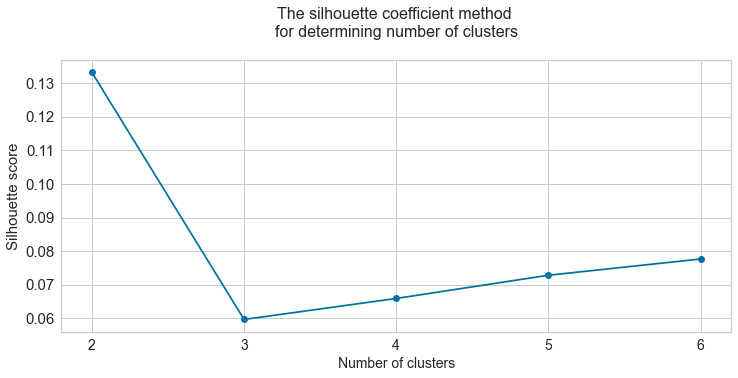

In [88]:
plt.figure(figsize=(12,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.plot([i for i in range(2,7)], km_silhouette, marker = 'o')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('the_silhouette_coefficient_method.png')
plt.show()

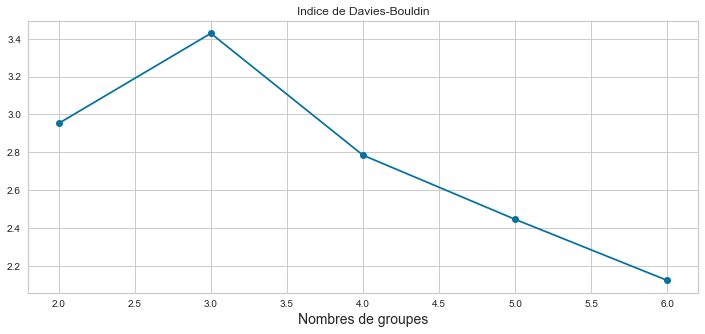

In [89]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,7)], db_score, marker = 'o')
plt.grid(True)
plt.xlabel('Nombres de groupes',fontsize=14)
plt.title("Indice de Davies-Bouldin")
plt.savefig('davies_bouldin_score.png')
plt.show()

#### <span class="bg-warning"> 6.3.3 Visualisation, k-prototypes, k=6<span>

In [90]:
#Table de données Kprot_data
kprot_data = df_UMAP.copy()

#Pre-processing
for c in df_UMAP.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = [13,14] 

#Actual clustering
kproto = KPrototypes(n_clusters= 6, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(clusters).value_counts()

3    1232
0    1123
2     959
5     875
4     696
1     384
dtype: int64

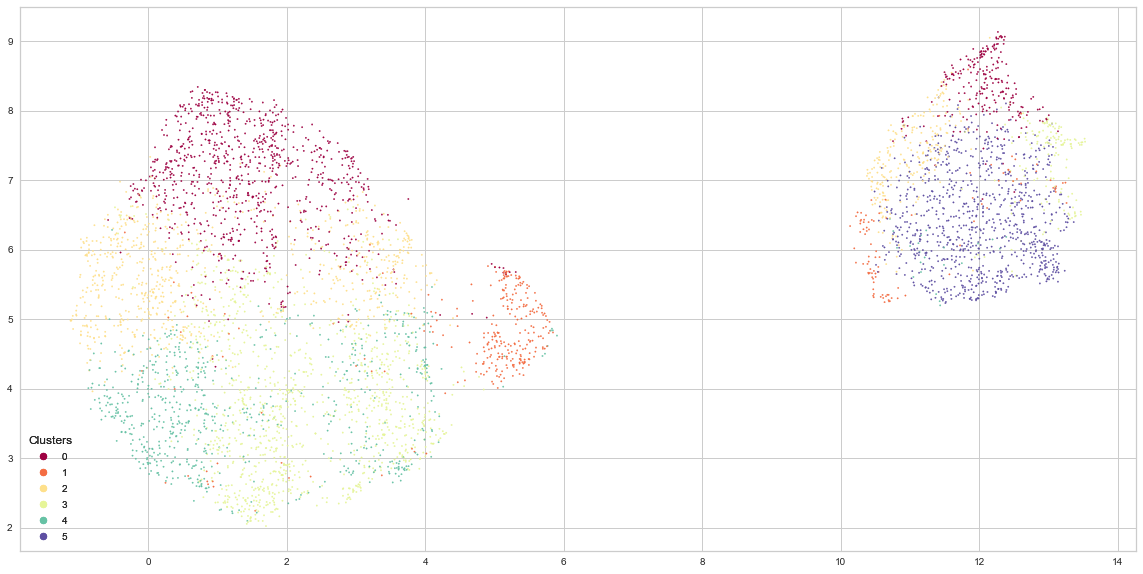

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='Spectral', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=6),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

#### <span class="bg-warning"> 6.3.4 Interprétation des clusters - K prototypes - k = 6<span> 

In [92]:
#Setting the objects to category 
lgbm_data = df_UMAP.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [93]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9519153278344368


### Importance des variables dans la formation des différents clusters

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


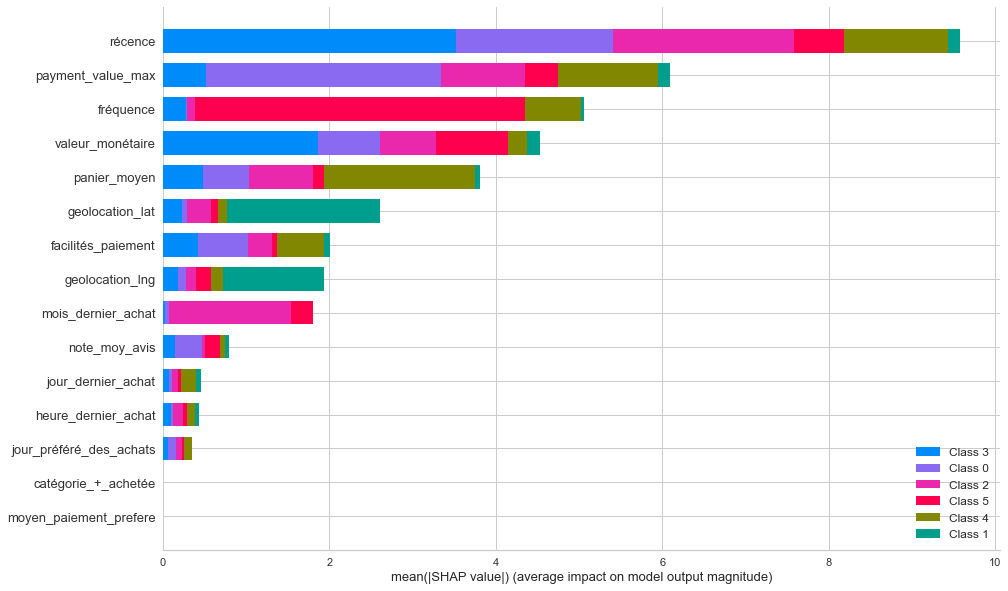

In [94]:
#Fit the model
clf_kp.fit(lgbm_data, clusters)

#SHAP values
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

In [95]:
df_UMAP['Cluster_Kp6'] = kproto.labels_

In [96]:
pd.Series(clusters).value_counts()

3    1232
0    1123
2     959
5     875
4     696
1     384
dtype: int64

### Top catégories

In [122]:
df_categories_clusters = df_UMAP.filter(items = ['catégorie_+_achetée','Cluster_Kp6'])

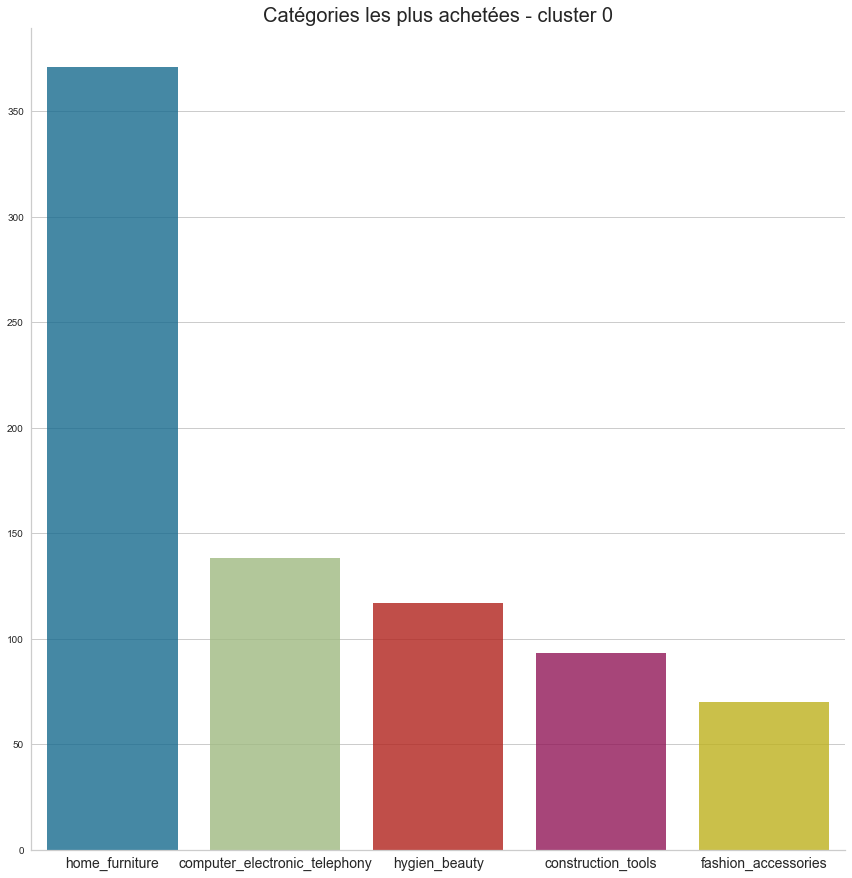

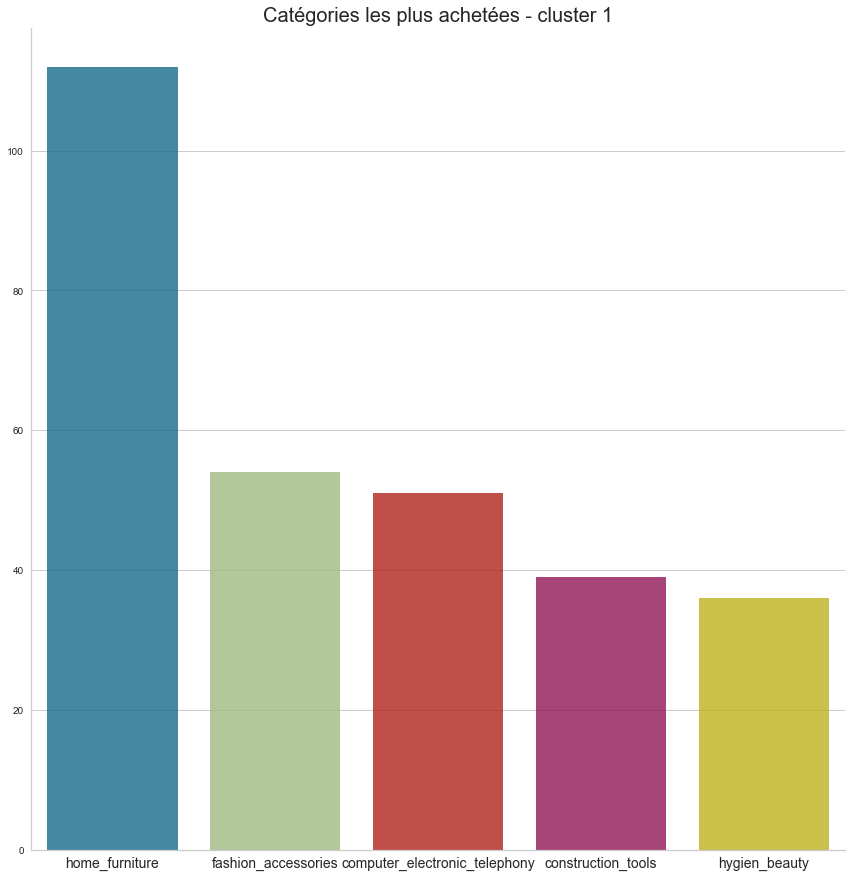

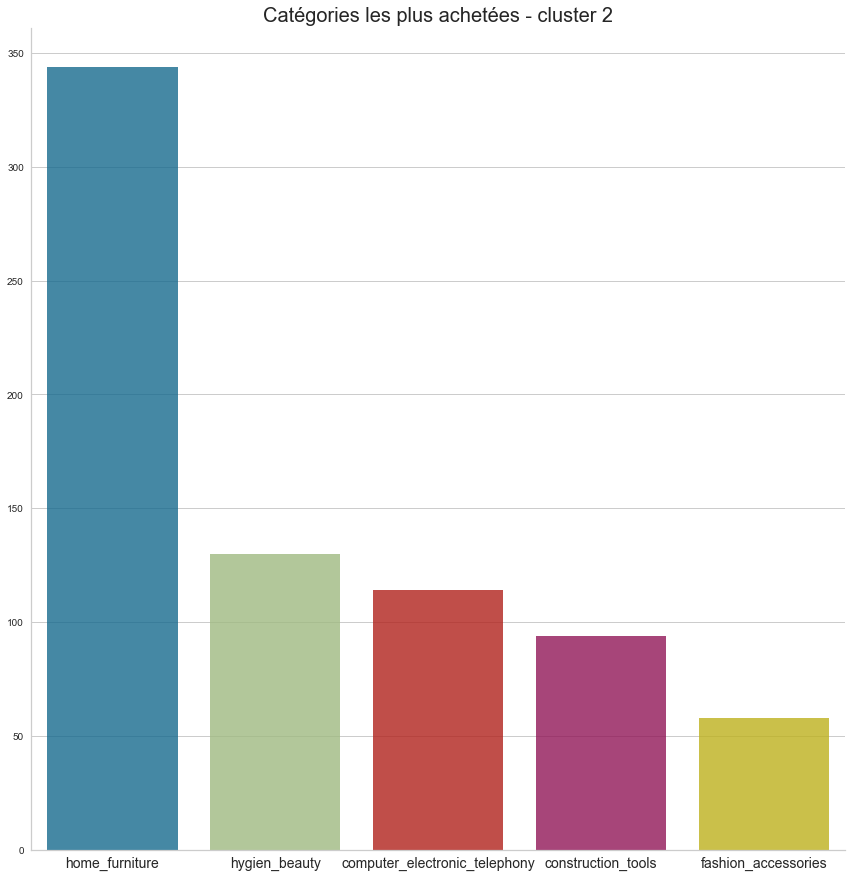

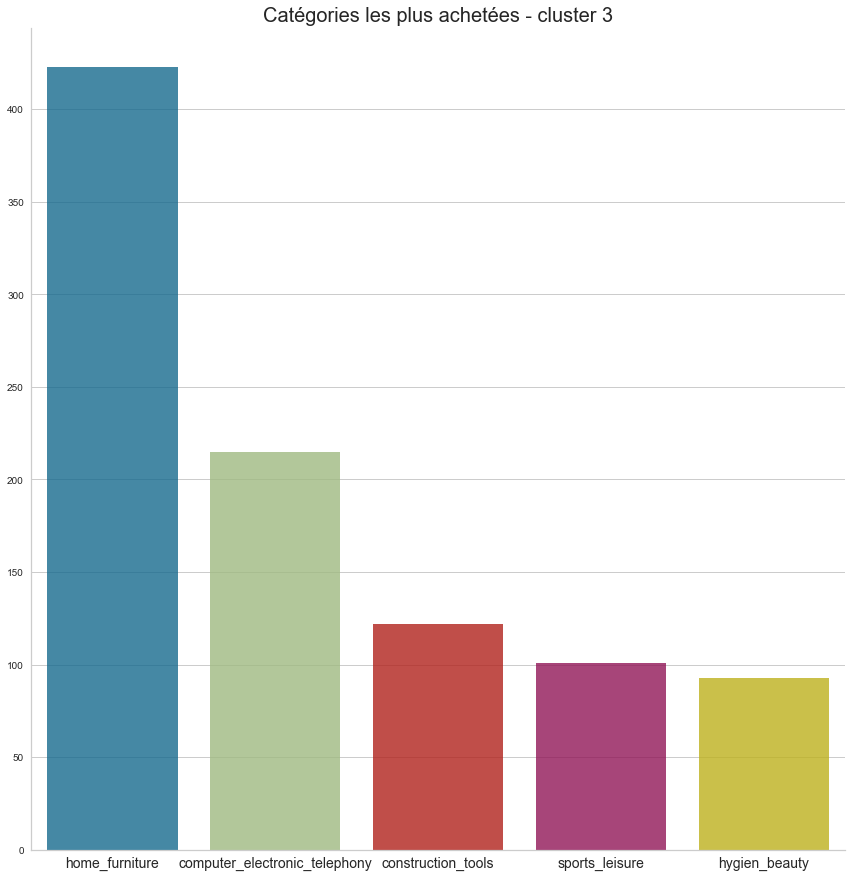

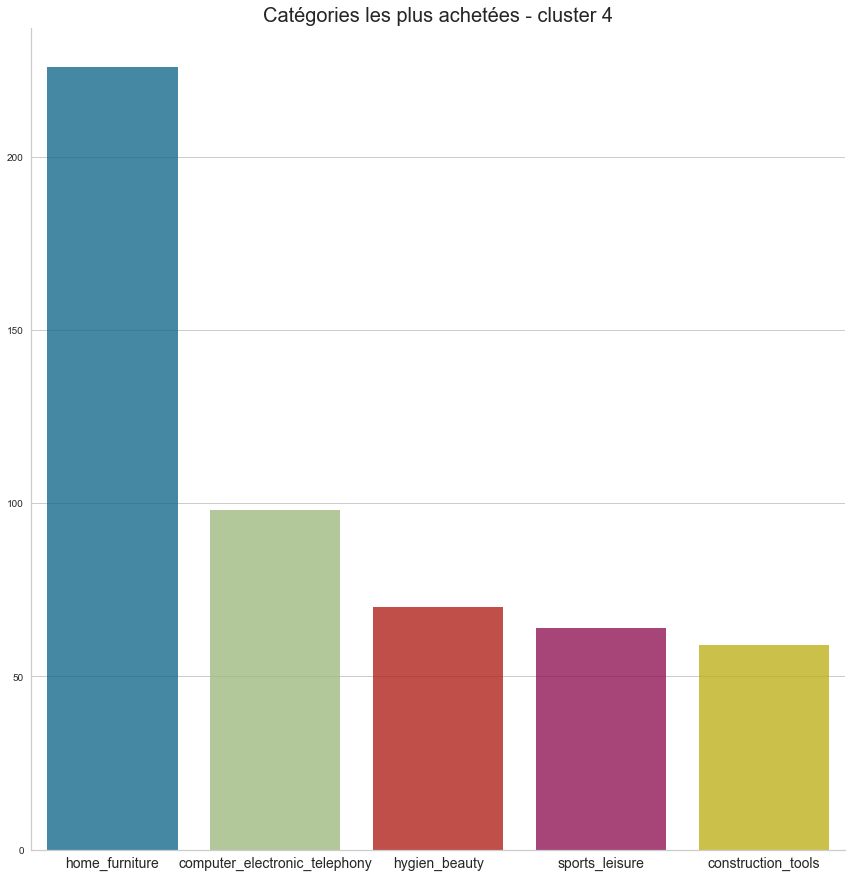

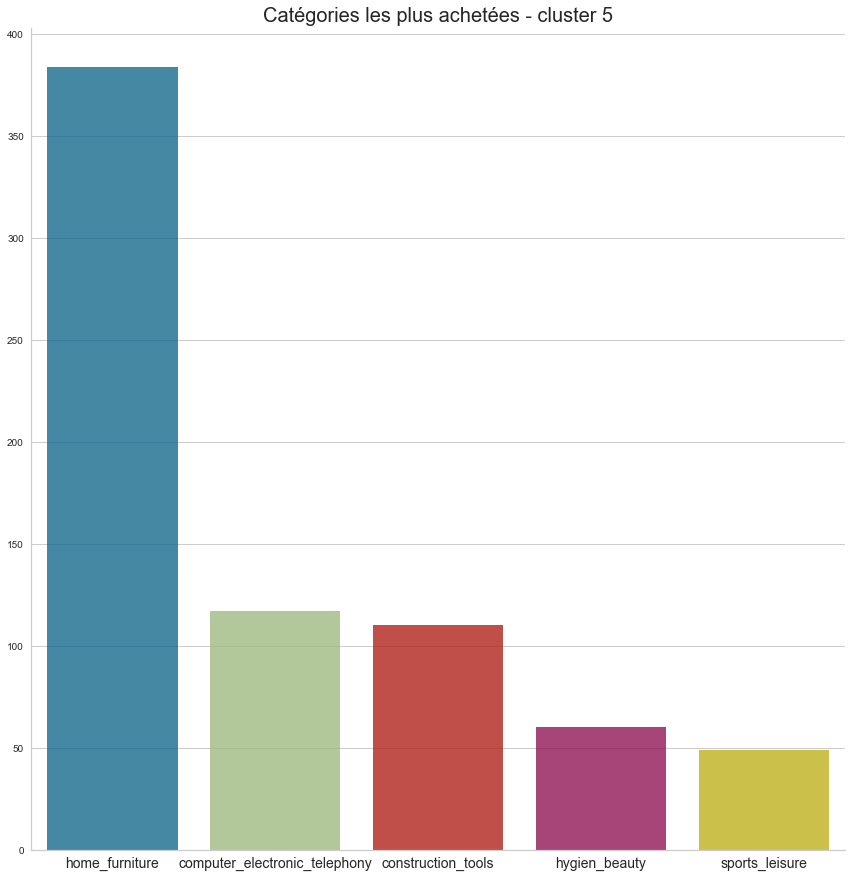

In [123]:
# 5 catégories les plus achetées par cluster
for i in range(0,6):
    df = df_categories_clusters[df_categories_clusters['Cluster_Kp6'] == i ].groupby('catégorie_+_achetée').count().sort_values(by = 'Cluster_Kp6', ascending = False).head(5)
    df = df.reset_index()
    g = sns.catplot(data= df, kind="bar", x=df['catégorie_+_achetée'].unique(), y=df['Cluster_Kp6'].values, ci="sd", alpha=.8, height=12)
    plt.xticks(fontsize=14)
    plt.title("Catégories les plus achetées - cluster {}".format(i), fontsize = 20)
    plt.show()

In [124]:
# Table de données pour interpréter la segmentation des clients pour kp=6
df_interpretation_kp_6 = df_UMAP.groupby('Cluster_Kp6').agg(
                                            {'récence' : 'mean', 
                                             'valeur_monétaire' : 'mean',
                                             'fréquence' : 'mean',
                                            'mois_dernier_achat' : 'median',
                                            'panier_moyen': 'mean',
                                            'facilités_paiement' : 'median',
                                            'geolocation_lat' : 'median',
                                            'catégorie_+_achetée' :lambda x: x.mode()[0],
                                            'moyen_paiement_prefere' :lambda x: x.mode()[0]})
df_interpretation_kp_6.reset_index(inplace = True)
df_interpretation_kp_6

Cluster_Kp6     récence  valeur_monétaire  fréquence  mois_dernier_achat  \
0            0   57.858415          5.317775   2.384684                   7   
1            1  118.046875          6.177475   2.492188                   4   
2            2   40.532847          6.267462   2.425443                   7   
3            3  161.047890          5.693401   2.163961                   3   
4            4  145.130747          6.532042   2.037356                   4   
5            5  134.282286          6.978169   4.392000                   4   

   panier_moyen  facilités_paiement  geolocation_lat catégorie_+_achetée  \
0      3.716458                 1.0       -23.439927      home_furniture   
1      4.555814                 3.0        -9.151795      home_furniture   
2      4.707581                 3.0       -23.200076      home_furniture   
3      4.182677                 2.0       -23.009118      home_furniture   
4      5.222531                 4.5       -22.929128      home_furniture   
5      4.227709                 3.0       -23.036935      home_furniture   

  moyen_paiement_prefere  
0            credit_card  
1            credit_card  
2            credit_card  
3            credit_card  
4            credit_card  
5            credit_card

In [125]:
df_interpretation_kp_6.filter(items = ['Cluster_Kp6', 'catégorie_+_achetée'])

Cluster_Kp6 catégorie_+_achetée
0            0      home_furniture
1            1      home_furniture
2            2      home_furniture
3            3      home_furniture
4            4      home_furniture
5            5      home_furniture

### Top moyens paiement

In [129]:
df_moyens_paiement_clusters = df_UMAP.filter(items = ['moyen_paiement_prefere','Cluster_Kp6'])

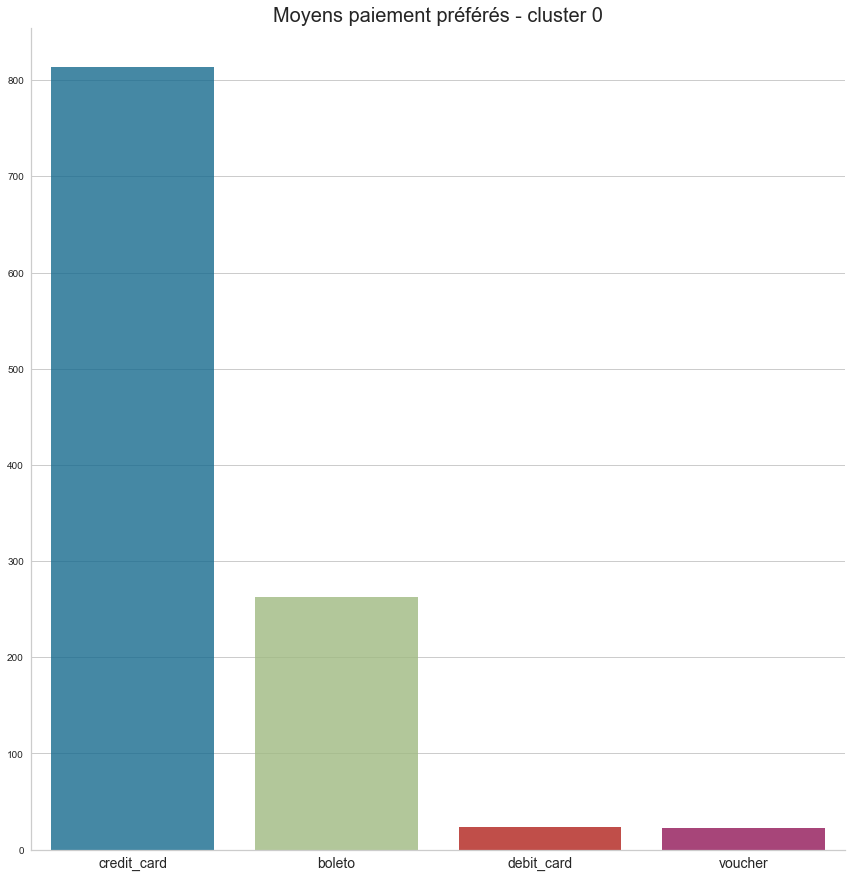

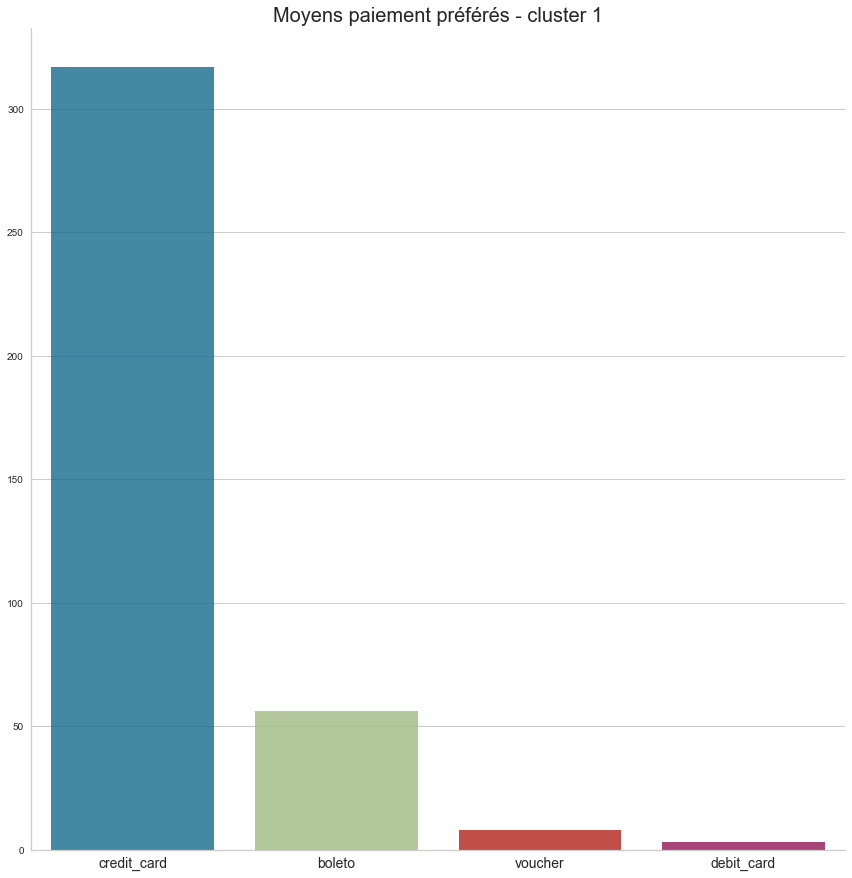

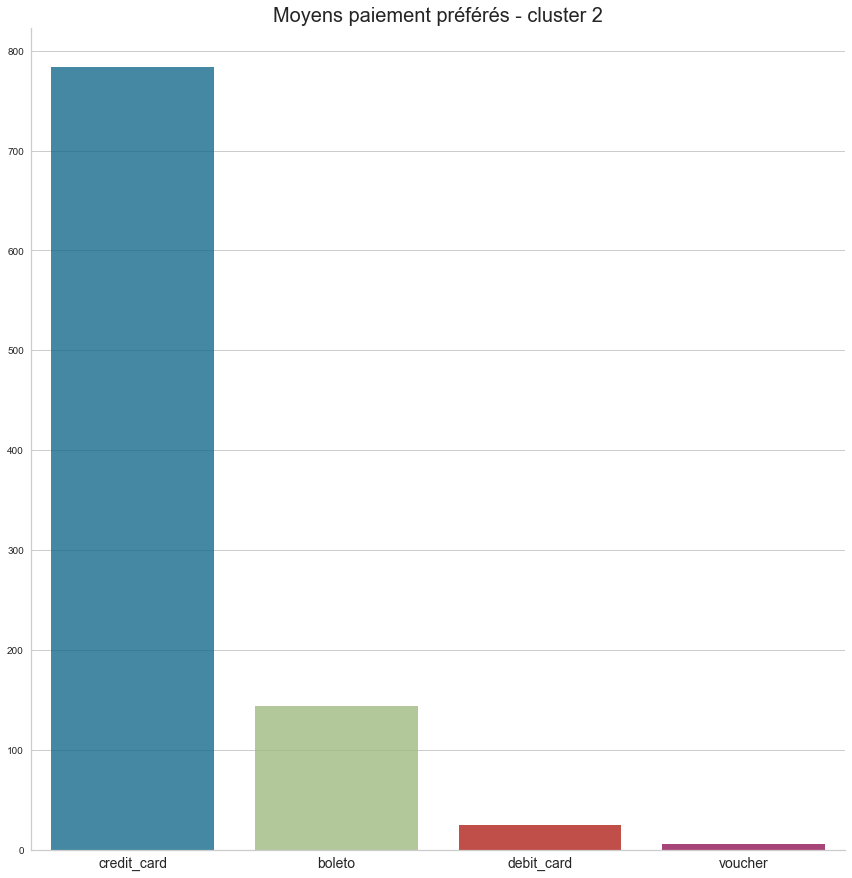

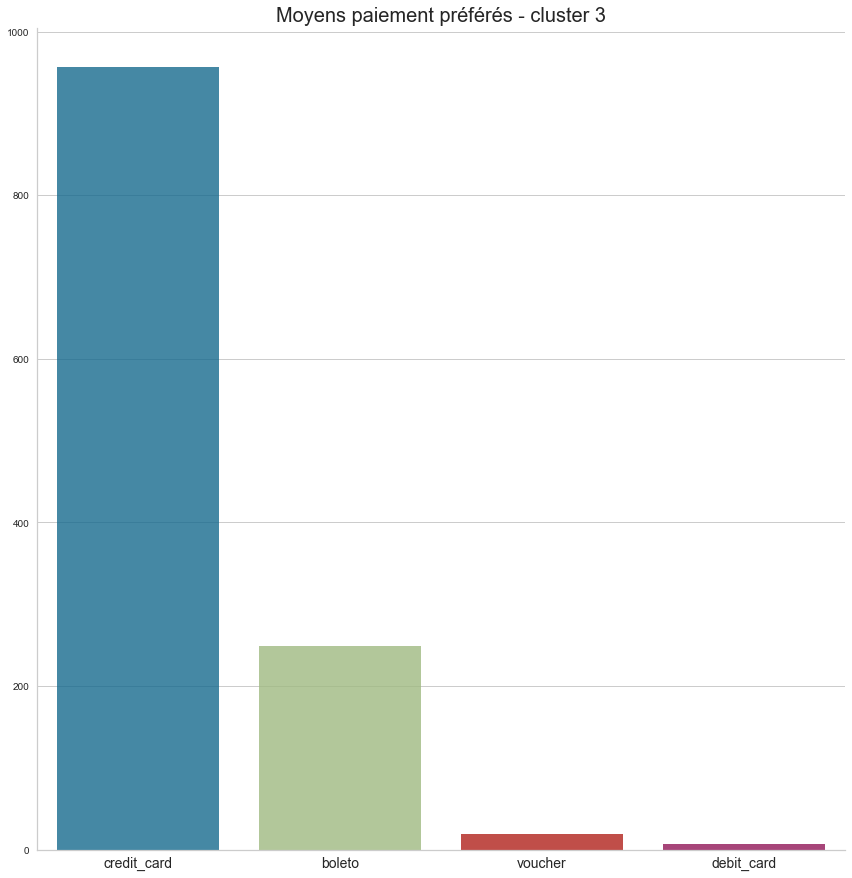

In [130]:
# top 3 moyens de paiement par cluster
for i in range(0,4):
    df = df_moyens_paiement_clusters[df_moyens_paiement_clusters['Cluster_Kp6'] == i ].groupby('moyen_paiement_prefere').count().sort_values(by = 'Cluster_Kp6', ascending = False).head(5)
    df = df.reset_index()
    g = sns.catplot(data= df, kind="bar", x=df['moyen_paiement_prefere'].unique(), y=df['Cluster_Kp6'].values, ci="sd", alpha=.8, height=12)
    plt.xticks(fontsize=14)
    plt.title("Moyens paiement préférés - cluster {}".format(i), fontsize = 20)
    plt.show()

In [127]:
df_interpretation_kp_6.filter(items = ['Cluster_Kp6', 'moyen_paiement_prefere'])

Cluster_Kp6 moyen_paiement_prefere
0            0            credit_card
1            1            credit_card
2            2            credit_card
3            3            credit_card
4            4            credit_card
5            5            credit_card

### Graphiques utiles à l'interprétation des clusters

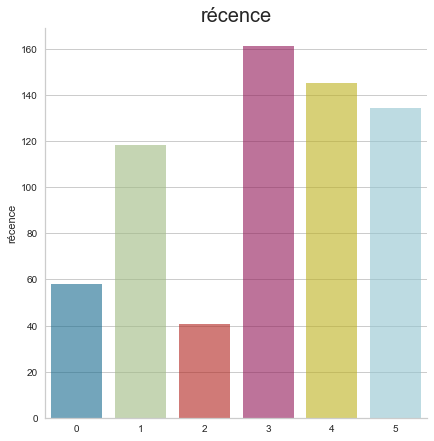

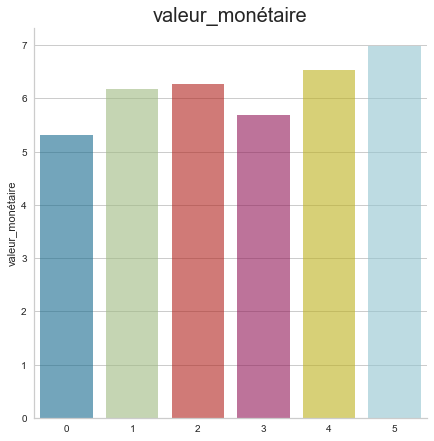

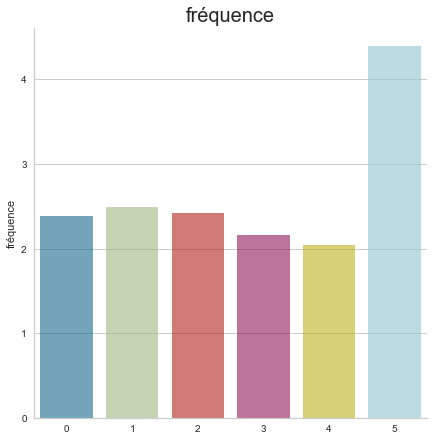

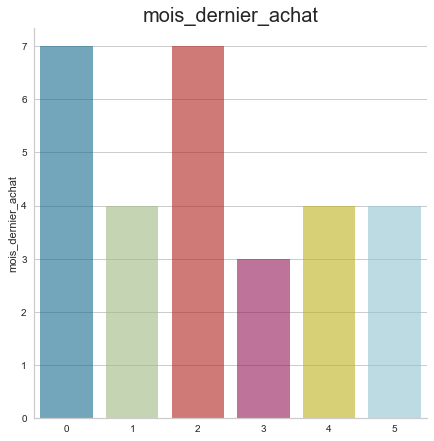

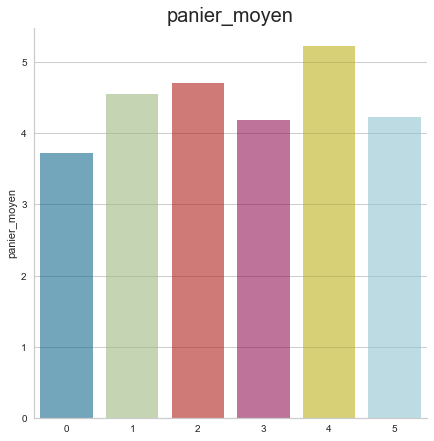

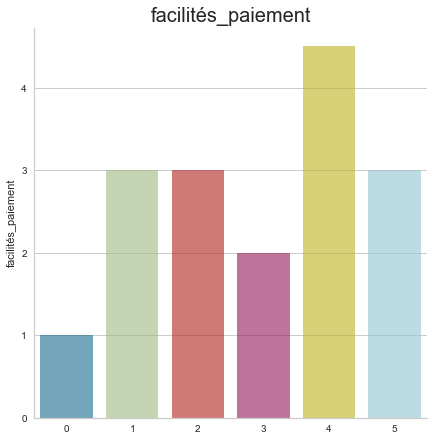

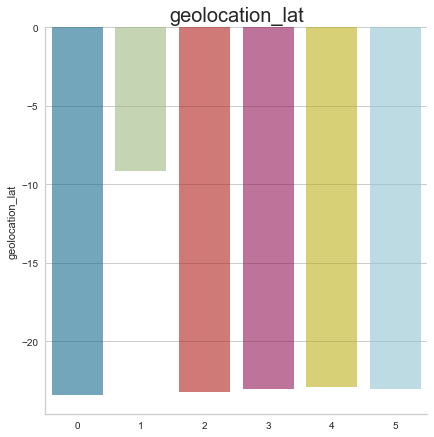

In [126]:
#Graphiques utiles à l'interprétation des clusters
colonnes = ['récence', 'valeur_monétaire', 'fréquence', 'mois_dernier_achat', 'panier_moyen', 'facilités_paiement','geolocation_lat']
for col in colonnes :
    g = sns.catplot(
    data= df_interpretation_kp_6, kind="bar", x='Cluster_Kp6', y=col, ci="sd", alpha=.6, height=6)
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

### Cluster 4 caractérisé fortement par la géolocalisation : où habitent les consommateurs du cluster 4?

In [115]:
graph = pd.DataFrame(data = [kproto.labels_]).T

In [116]:
graph.columns = ['label']

In [117]:
graph['colors']=pd.cut(graph['label'], bins=6, 
                       labels=['blue', 'olive','red', 'fuchsia', 'mediumseagreen', 'mediumpurple'])

In [118]:
graph.shape

(5269, 2)

In [119]:
df_clients_or_kp.shape

(5269, 15)

In [120]:
import folium
n = folium.Map()
n = folium.Map(location=[df_clients_or_kp['geolocation_lat'].mean(), df_clients_or_kp['geolocation_lng'].mean()],
                   zoom_start=4)
for i in range(0,5269):    
    folium.Circle([df_clients_or_kp.iloc[i]['geolocation_lat'],df_clients_or_kp.iloc[i]['geolocation_lng']],
                      popup=graph.iloc[i]['label'], 
                      color = graph.iloc[i]['colors']
                      ,radius =500).add_to(n)

In [121]:
n

## <span class="bg-info"> 5. Segmentation des clients avec la classification hierarchique ascendante<span>

In [131]:
# préparation des données pour le clustering
X = df_clients_or_PCA.values
names = df_clients_or_PCA.index

In [132]:
df_clients_or_PCA.shape

(5269, 10)

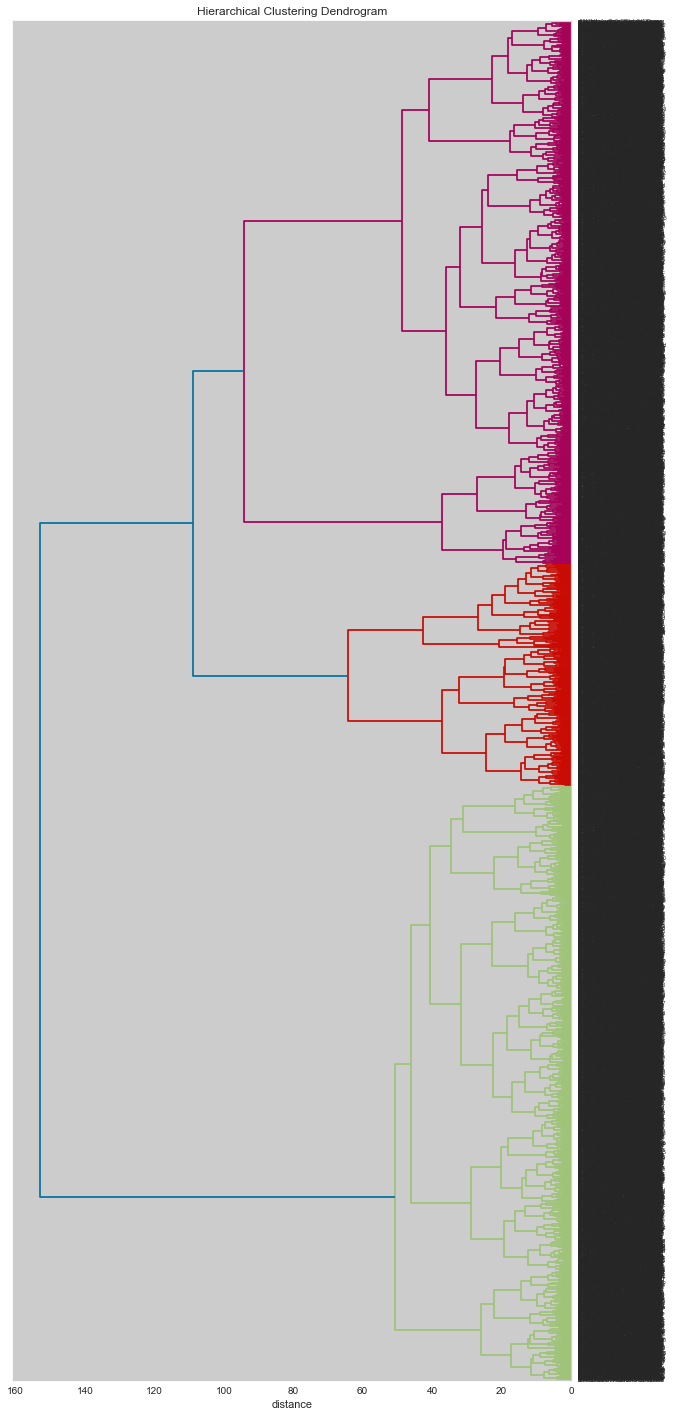

In [133]:
from scipy.cluster.hierarchy import linkage, fcluster
# Clustering hiérarchique
Z = linkage(X, 'ward')

# Affichage du dendrogramme
PCA_NR.plot_dendrogram(Z, names)

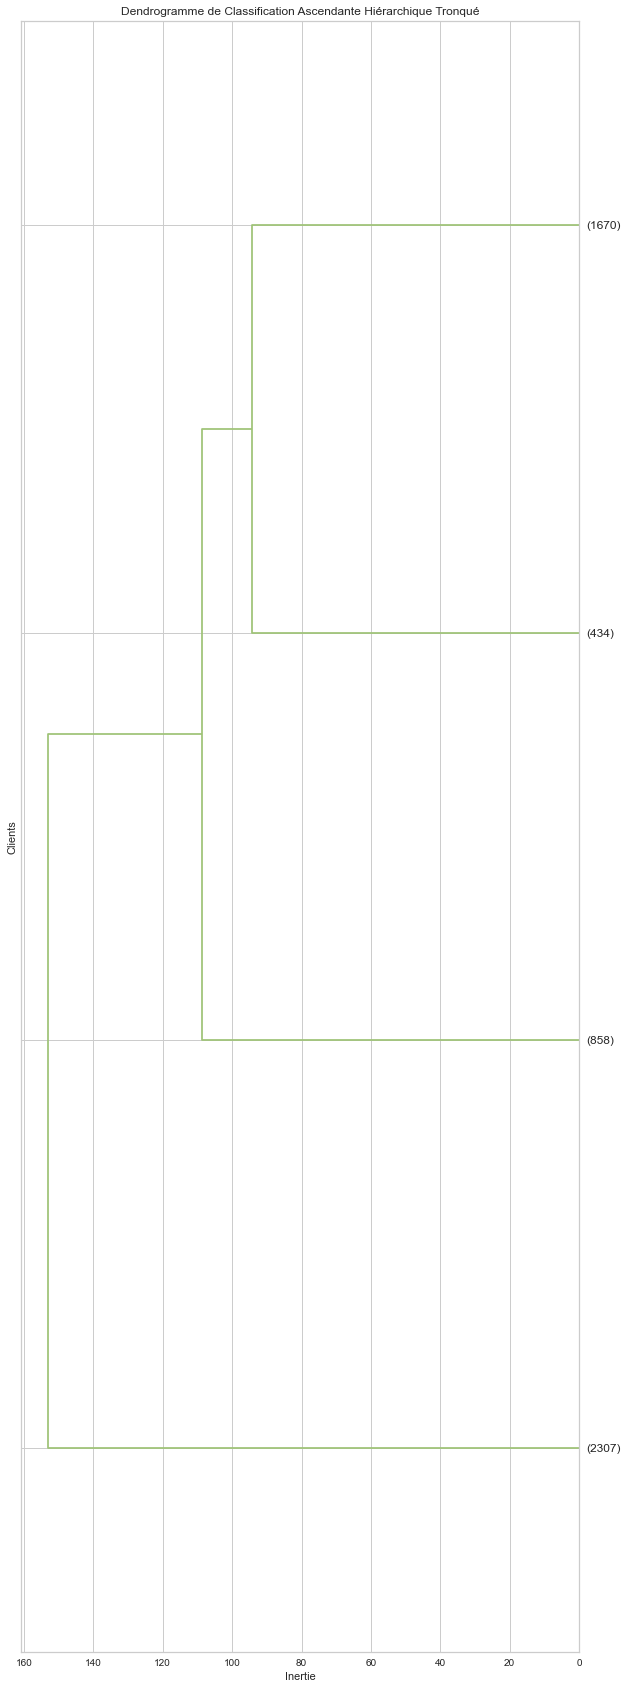

In [134]:
plt.figure(figsize=(10,30))
plt.title('Dendrogramme de Classification Ascendante Hiérarchique Tronqué')
plt.xlabel("Inertie")
plt.ylabel('Clients')
truncate_dendro = sch.dendrogram(Z,labels =  names,color_threshold=1200, orientation='left', p=4, truncate_mode='lastp')
plt.show(truncate_dendro)